# Metric-based Quantum Architecture Search

## Required imports

In [4]:
import numpy as np
import scipy

import time
import os

from itertools import combinations, product
from functools import reduce
import copy

import pennylane as qml
# from pennylane.templates.layers import RandomLayers

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

# from sklearn.datasets import make_moons

# from scipy.signal import savgol_filter
# from scipy.stats import entropy
# from matplotlib.lines import Line2D
# from mpl_toolkits.mplot3d import Axes3D

# from sklearn.decomposition import PCA
# from sklearn.neighbors import NearestNeighbors, DistanceMetric
# from sklearn.utils import graph_shortest_path

# import torch
# import torchquantum as tq
# import torchquantum.functional as tqf

In [4]:
!pip install pennylane
!pip install matplotlib

  Using cached PennyLane-0.25.1-py3-none-any.whl (1.0 MB)
  Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl (15 kB)
  Using cached autograd-1.4-py3-none-any.whl (48 kB)
  Using cached retworkx-0.11.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached networkx-2.6.3-py3-none-any.whl (1.9 MB)
  Using cached autoray-0.3.2-py3-none-any.whl (36 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
  Using cached PennyLane_Lightning-0.25.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.6 MB)
  Using cached ninja-1.10.2.3-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (108 kB)
  Using cached future-0.18.2-py3-none-any.whl
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using c

## Losses

In [165]:
def mae_loss(label, pred):
    return tf.abs(pred - label)


def mse_loss(label, pred):
    return tf.abs(pred - label) ** 2


def mse_vec_loss(label, pred):
    diff_vec = tf.math.subtract(label, pred)
    return tf.math.sqrt(tf.reduce_sum(tf.math.multiply(diff_vec, diff_vec)))


def log_loss_prob(label, probs):
    return -0.5 * ((1 + label) * tf.math.log(probs[0]) + (1 - label) * tf.math.log(probs[1]))


def log_loss_exp(label, exp):
    prob_0 = (exp + 1) / 2
    return -0.5 * ((1 + label) * tf.math.log(prob_0) + (1 - label) * tf.math.log(1 - prob_0))


def zero_prob_loss(label, pred):
    return pred[0]


def hinge_loss(label, pred):
    return 1 - pred * label


def cat_ce_loss(label, pred):
    probs = tf.math.divide(tf.math.exp(pred), tf.math.reduce_sum(tf.math.exp(pred)))
    ret = -1 * tf.math.reduce_sum(tf.math.multiply(tf.math.log(probs), label))

    return ret 


def cat_ce_loss_4(label, pred):
    pool = tf.math.unsorted_segment_mean(pred, tf.constant([0, 0, 1, 1]), num_segments=2)

    return cat_ce_loss(label, pool)

In [1539]:
x_train = np.genfromtxt('./experiment_data/moons_300/x_train.txt')[:, :4]
# x_train = np.concatenate((x_train, x_train), 1)[:48]
x_test = np.genfromtxt('./experiment_data/moons_300/x_test.txt')[:, :4]
# x_test = np.concatenate((x_test, x_test), 1)[:48]
y_train = np.genfromtxt('./experiment_data/moons_300/y_train.txt')[:, 0]
y_train = 2 * y_train - 1
y_test = np.genfromtxt('./experiment_data/moons_300/y_test.txt')[:, 0]
y_test = 2 * y_test - 1

num_qubits = 2
num_embeds = 4
num_params = 8

for i in range(1):
    curr_dir = './experiment_data/moons_300/trained_circuits/circ_{}'.format(i + 1)
    circ_gates, gate_params, inputs_bounds, weights_bounds = get_circ_params(curr_dir) 

    circ = create_gate_circ(qml.device('lightning.qubit', wires=num_qubits), circ_gates, gate_params, inputs_bounds,
                                                    weights_bounds, [0], 'exp')    

    losses_list = []
    accs_list = []
    
    for j in range(5):
        curr_train_dir = curr_dir + '/run_{}'.format(j + 1)

        if os.path.exists(curr_train_dir):
            pass
        else:
            os.mkdir(curr_train_dir)
    
        
        info = train_qnn(circ, x_train, y_train, x_test, y_test, [num_params], 2400, 0.05, 1, mse_loss, verbosity=7300, 
                                                                                        loss_window=50, init_params=None, 
                                                                                        acc_thres=1.1, shuffle=True, print_loss=50)
        
        val_exps = [circ(x_test[i], info[-1][-1]) for i in range(len(x_test))]
        val_loss = np.array([mse_loss(y_test[k], val_exps[k]) for k in range(len(x_test))]).flatten()

        acc = np.mean(val_loss < 1)
        
        np.savetxt(curr_train_dir + '/params_{}.txt'.format(j + 1), info[-1])
        np.savetxt(curr_train_dir + '/losses_{}.txt'.format(j + 1), info[0])
        
        losses_list.append(val_loss)
        accs_list.append(acc)
        
    np.savetxt(curr_dir + '/val_losses.txt', losses_list)
    np.savetxt(curr_dir + '/accs.txt', accs_list)

Step 1 | Sliding Loss Window : 0.14724097912193873
Step 51 | Sliding Loss Window : 0.8797797975777335
Step 101 | Sliding Loss Window : 0.7278987163347023
Step 151 | Sliding Loss Window : 0.9047257292106896
Step 201 | Sliding Loss Window : 0.6733705800959311
Step 251 | Sliding Loss Window : 0.8848471796258438
Step 301 | Sliding Loss Window : 0.8845285894523941
Step 351 | Sliding Loss Window : 0.8602212416077587
Step 401 | Sliding Loss Window : 0.7505294566545649
Step 451 | Sliding Loss Window : 0.6614031358382886
Step 501 | Sliding Loss Window : 0.8136931423089058
Step 551 | Sliding Loss Window : 0.6981901272403997
Step 601 | Sliding Loss Window : 0.6972015733047705
Step 651 | Sliding Loss Window : 0.9005761153623365
Step 701 | Sliding Loss Window : 0.7212029844556668
Step 751 | Sliding Loss Window : 0.8551340719064915
Step 801 | Sliding Loss Window : 0.924130859521839
Step 851 | Sliding Loss Window : 0.805276209783161
Step 901 | Sliding Loss Window : 0.7119096290395146
Step 951 | Slidi

## Train random circuits

In [ ]:
x_train = np.genfromtxt('./experiment_data/fmnist_4/x_train.txt')
x_test = np.genfromtxt('./experiment_data/fmnist_4/x_test.txt')

y_train = np.genfromtxt('./experiment_data/fmnist_4/y_train.txt')
# y_train = 1 - 2 * y_train
y_test = np.genfromtxt('./experiment_data/fmnist_4/y_test.txt')
# y_test = 1 - 2 * y_test

num_params = [12, 16, 20, 24]

num_qubits = 4
num_embeds = 16

dev = qml.device('lightning.qubit', wires=num_qubits)

for curr_num_params in num_params:
    curr_dir = './random/fmnist_4/{}_params'.format(curr_num_params)
    
    if not os.path.exists(curr_dir):
        os.mkdir(curr_dir)
        
    for i in range(5, 20):
        curr_circ_dir = curr_dir + '/circ_{}'.format(i + 1)
        
        if not os.path.exists(curr_circ_dir):
            os.mkdir(curr_circ_dir)
        
        ent_prob = np.random.sample()
        cxz = np.random.sample()
        pauli = 0

        circ_gates, gate_params, inputs_bounds, weights_bounds = generate_true_random_gate_circ(num_qubits, num_embeds, curr_num_params, 
                                                                                                        ent_prob=ent_prob, 
                                                                                                        cxz_prob=cxz * ent_prob,
                                                                                                        pauli_prob=pauli * (
                                                                                                            1 - cxz) * ent_prob)
        
#         circ_gates = ['h'] * num_qubits + ['rz'] * num_qubits + ['zz'] * (num_qubits - 1) + circ_gates
#         gate_params = [[i] for i in range(num_qubits)] * 2 + [[i, i + 1] for i in range(num_qubits - 1)] + gate_params
#         weights_bounds = [0] * (3 * num_qubits - 1) + weights_bounds
#         inputs_bounds = [0] * (num_qubits + 1) + [i + 1 for i in range(num_qubits)] +\
#             [i + num_qubits + 1 for i in range(num_qubits - 1)] + [2 * num_qubits - 1 for l in range(len(inputs_bounds) - 1)]
        
        
        np.savetxt(curr_circ_dir + '/gates.txt', circ_gates, fmt="%s")
        np.savetxt(curr_circ_dir + '/gate_params.txt', gate_params, fmt="%s")
        np.savetxt(curr_circ_dir + '/inputs_bounds.txt', inputs_bounds)
        np.savetxt(curr_circ_dir + '/weights_bounds.txt', weights_bounds)
        
        circ = create_gate_circ(dev, circ_gates, gate_params, inputs_bounds,
                                                        weights_bounds, [0, 1], 'exp', 'adjoint') 

        losses_list = []
        accs_list = []
        
        for j in range(5):
            curr_train_dir = curr_circ_dir + '/run_{}'.format(j + 1)

            if os.path.exists(curr_train_dir):
                pass
            else:
                os.mkdir(curr_train_dir)
                        
            info = train_qnn(circ, x_train, y_train, x_test, y_test, [weights_bounds[-1]], 16000, 0.05, 1, mse_vec_loss, verbosity=17300, 
                                                                                            loss_window=50, init_params=None, 
                                                                                            acc_thres=1.1, shuffle=True, print_loss=50)

            val_exps = [circ(x_test[i], info[-1][-1]) for i in range(len(x_test))]
            val_loss = np.array([mse_vec_loss(y_test[k], val_exps[k]) for k in range(len(x_test))]).flatten()

            acc = np.mean(np.sum(np.multiply(val_exps, y_test) > 0, 1) == 2)

            np.savetxt(curr_train_dir + '/params_{}.txt'.format(j + 1), info[-1])
            np.savetxt(curr_train_dir + '/losses_{}.txt'.format(j + 1), info[0])

            losses_list.append(val_loss)
            accs_list.append(acc)

        np.savetxt(curr_circ_dir + '/accs.txt', accs_list)
        np.savetxt(curr_circ_dir + '/val_losses.txt', losses_list)   

In [985]:
x_train = np.genfromtxt('./experiment_data/mnist_2/x_train.txt')[:, :16]
x_test = np.genfromtxt('./experiment_data/mnist_2/x_test.txt')[:, :16]

extra_embeds_train = np.zeros((len(x_train), len(x_train)))
extra_embeds_test = np.zeros((len(x_test), len(x_test)))

for i in range(len(x_train[0])):
    extra_embeds_train[:, i] = x_train[:, i] * x_train[:, (i + 1) % len(x_train[0])]
    extra_embeds_test[:, i] = x_test[:, i] * x_test[:, (i + 1) % len(x_train[0])]
    
x_train = np.concatenate((x_train, extra_embeds_train), 1)
x_test = np.concatenate((x_test, extra_embeds_test), 1)

y_train = np.genfromtxt('./experiment_data/mnist_2/y_train.txt')
# y_train = 1 - 2 * y_train
y_test = np.genfromtxt('./experiment_data/mnist_2/y_test.txt')
# y_test = 1 - 2 * y_test

num_params = [4, 8, 12, 16, 20]

num_qubits = 4
num_embeds = 0

dev = qml.device('lightning.qubit', wires=num_qubits)

for curr_num_params in num_params:
    curr_dir = './random_fe/iqp_1/mnist_2/{}_params'.format(curr_num_params)
    
    if not os.path.exists(curr_dir):
        os.mkdir(curr_dir)
        
    for i in range(5):
        curr_circ_dir = curr_dir + '/circ_{}'.format(i + 1)
        
        if not os.path.exists(curr_circ_dir):
            os.mkdir(curr_circ_dir)
        
        ent_prob = np.random.sample()
        cxz = np.random.sample()
        pauli = 0

        circ_gates, gate_params, inputs_bounds, weights_bounds = generate_true_random_gate_circ(num_qubits, num_embeds, curr_num_params, 
                                                                                                        ent_prob=ent_prob, 
                                                                                                        cxz_prob=cxz * ent_prob,
                                                                                                        pauli_prob=pauli * (
                                                                                                            1 - cxz) * ent_prob)
        
        extra_circ_gates = ['h'] * num_qubits + ['rz'] * num_qubits + ['zz'] * (num_qubits - 1) 
        circ_gates = extra_circ_gates * 1 + circ_gates
        
        extra_gate_params = [[i] for i in range(num_qubits)] * 2 + [[i, i + 1] for i in range(num_qubits - 1)]
        gate_params = extra_gate_params * 1 + gate_params
        
        weights_bounds = [0] * (3 * num_qubits - 1) + weights_bounds
        
        inputs_bounds = [0] * (num_qubits + 1) + [i + 1 for i in range(num_qubits)] +\
            [i + num_qubits + 1 for i in range(num_qubits - 1)] + [2 * num_qubits - 1 for i in range(len(inputs_bounds) - 1)]
        
        
        np.savetxt(curr_circ_dir + '/gates.txt', circ_gates, fmt="%s")
        np.savetxt(curr_circ_dir + '/gate_params.txt', gate_params, fmt="%s")
        np.savetxt(curr_circ_dir + '/inputs_bounds.txt', inputs_bounds)
        np.savetxt(curr_circ_dir + '/weights_bounds.txt', weights_bounds)
        
        circ = create_gate_circ(dev, circ_gates, gate_params, inputs_bounds,
                                                        weights_bounds, [0], 'exp', 'adjoint') 

        losses_list = []
        accs_list = []
        
        print(circ_gates)
        print(inputs_bounds)
        print(weights_bounds)
        
        for j in range(5):
            curr_train_dir = curr_circ_dir + '/run_{}'.format(j + 1)

            if os.path.exists(curr_train_dir):
                pass
            else:
                os.mkdir(curr_train_dir)
                        
            info = train_qnn(circ, x_train, y_train, x_test, y_test, [weights_bounds[-1]], 8000, 0.05, 1, mse_loss, verbosity=7300, 
                                                                                            loss_window=50, init_params=None, 
                                                                                            acc_thres=1.1, shuffle=True, print_loss=50)

            val_exps = [circ(x_test[i], info[-1][-1]) for i in range(len(x_test))]
            val_loss = np.array([mse_loss(y_test[k], val_exps[k]) for k in range(len(x_test))]).flatten()

            acc = np.mean(val_loss < 1)

            np.savetxt(curr_train_dir + '/params_{}.txt'.format(j + 1), info[-1])
            np.savetxt(curr_train_dir + '/losses_{}.txt'.format(j + 1), info[0])

            losses_list.append(val_loss)
            accs_list.append(acc)

        np.savetxt(curr_circ_dir + '/accs.txt', accs_list)
        np.savetxt(curr_circ_dir + '/val_losses.txt', losses_list)   

['h', 'h', 'h', 'h', 'rz', 'rz', 'rz', 'rz', 'zz', 'zz', 'zz', 'cry', 'rx', 'ry', 'rz', 'rx', 'rx']
[0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 7, 7, 7, 7, 7, 7]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6]
Step 1 | Sliding Loss Window : 0.5055194304307528
Step 51 | Sliding Loss Window : 1.0719460535756944
Step 101 | Sliding Loss Window : 1.0372649376789977
Step 151 | Sliding Loss Window : 1.0195809363413815
Step 201 | Sliding Loss Window : 1.0003312083637175
Step 251 | Sliding Loss Window : 0.9665789418400565
Step 301 | Sliding Loss Window : 1.0258441853224582
Step 351 | Sliding Loss Window : 1.0254949038317818
Step 401 | Sliding Loss Window : 0.9509441421344773
Step 451 | Sliding Loss Window : 1.068588114252088
Step 501 | Sliding Loss Window : 1.0247453692073742
Step 551 | Sliding Loss Window : 1.0192726320111978
Step 601 | Sliding Loss Window : 1.0240162246289812
Step 651 | Sliding Loss Window : 1.0165125315919945
Step 701 | Sliding Loss Window : 1.0151427409480536
Step 751 | Sli

KeyboardInterrupt: 

## Trai human designed circuits

In [ ]:
x_train = np.genfromtxt('./experiment_data/mnist_2/x_train.txt')[:, :16].reshape((len(x_train), 4, 4))
x_test = np.genfromtxt('./experiment_data/mnist_2/x_test.txt')[:, :16].reshape((len(x_test), 4, 4))

y_train = np.genfromtxt('./experiment_data/mnist_2/y_train.txt')
# y_train = 1 - 2 * y_train
y_test = np.genfromtxt('./experiment_data/mnist_2/y_test.txt')
# y_test = 1 - 2 * y_test

num_params = [4, 8, 12, 16, 20]

num_qubits = 4
num_embed_layers = 4

dev = qml.device('lightning.qubit', wires=num_qubits)

var_layer_options = [[qml.RX], [qml.RY]] * 4
enc_layer_options = [['X'], ['Y']] * 2

for curr_num_params in num_params:
    curr_dir = './human_design/angle_basic/mnist_2/{}_params'.format(curr_num_params)
    
    if not os.path.exists(curr_dir):
        os.mkdir(curr_dir)
        
    curr_num_layers = curr_num_params // 4
    curr_weights_shape = (curr_num_layers, 1, num_qubits)
        
    for i in range(1):
        curr_circ_dir = curr_dir

        circ = generate_human_design_circ(dev, num_qubits, 'angle', 'basic', num_embed_layers, curr_num_layers, enc_layer_options, var_layer_options[:curr_num_layers], [0])

#         np.savetxt(curr_circ_dir + '/layers.txt', var_layer_options[:curr_num_layers], fmt="%s")
        
        losses_list = []
        accs_list = []
        
        for j in range(5):
            curr_train_dir = curr_circ_dir + '/run_{}'.format(j + 1)

            if os.path.exists(curr_train_dir):
                pass
            else:
                os.mkdir(curr_train_dir)
                        
            info = train_qnn(circ, x_train, y_train, x_test, y_test, curr_weights_shape, 5490, 0.05, 1, mse_loss, verbosity=17300, 
                                                                                            loss_window=50, init_params=None, 
                                                                                            acc_thres=1.1, shuffle=True, print_loss=50)

            val_exps = np.array([circ(x_test[i], info[-1][-1]) for i in range(len(x_test))])
            val_loss = np.array([mse_loss(y_test[k], val_exps[k]) for k in range(len(x_test))]).flatten()

            acc = np.mean(val_loss < 1)

            shape = np.array(info[-1]).shape
            
            np.savetxt(curr_train_dir + '/params_{}.txt'.format(j + 1), np.array(info[-1]).reshape(shape[0], np.product(shape[1:])))
            np.savetxt(curr_train_dir + '/losses_{}.txt'.format(j + 1), info[0])

            losses_list.append(val_loss)
            accs_list.append(acc)

        np.savetxt(curr_circ_dir + '/accs.txt', accs_list)
        np.savetxt(curr_circ_dir + '/val_losses.txt', losses_list) 

Step 1 | Sliding Loss Window : 0.6080114947779163
Step 51 | Sliding Loss Window : 0.8480693311915302
Step 101 | Sliding Loss Window : 0.9702521186219893
Step 151 | Sliding Loss Window : 0.851311820351677
Step 201 | Sliding Loss Window : 0.869113353969692
Step 251 | Sliding Loss Window : 0.7664660867063228
Step 301 | Sliding Loss Window : 0.8626756966731959
Step 351 | Sliding Loss Window : 0.8530643441826348
Step 401 | Sliding Loss Window : 0.9038556070074768
Step 451 | Sliding Loss Window : 0.7113632609376203
Step 501 | Sliding Loss Window : 0.6806903225093512
Step 551 | Sliding Loss Window : 0.8904588577314301
Step 601 | Sliding Loss Window : 0.6846109422125718
Step 651 | Sliding Loss Window : 0.8443562897920378
Step 701 | Sliding Loss Window : 0.6929753183478995
Step 751 | Sliding Loss Window : 0.8168592109039178
Step 801 | Sliding Loss Window : 0.9071795564424372
Step 851 | Sliding Loss Window : 0.7929879567656751
Step 901 | Sliding Loss Window : 0.8779510838409346
Step 951 | Slidin

In [ ]:
!python supernet/train_search.py --warmup_epochs 0 --epochs 250 --n_search 100 --n_qubits 2 --n_experts 1 --n_layers 2 --n_encode_layers 1 --save "4_params" --data "./supernet/moons_data" --save_dir "./supernet/moons"

2022-07-04 13:37:02.366484: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-07-04 13:37:02.372851: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2022-07-04 13:37:02.709374: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
(480, 1, 2) (120, 1, 2)
subnet: [20, 4], expert_idx: 0
2022-07-04 13:37:06.601872: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-04 13:37:06.631436: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2499995000 Hz
2022-07-04 13:37

## Compute metrics for our search

In [ ]:
search_params = [4, 8, 12, 16, 20]

ideal = np.concatenate((np.ones((16, 16)), np.zeros((16, 16))))
ideal = np.concatenate((ideal, ideal[::-1, :]), 1)

num_qubits = 4
num_embeds = 16

x_train = np.genfromtxt('./experiment_data/mnist_2/x_train.txt')[:, :16]
x_test = np.genfromtxt('./experiment_data/mnist_2/x_test.txt')[:, :16]

y_train = np.genfromtxt('./experiment_data/mnist_2/y_train.txt')
# y_train = 1 - 2 * y_train
y_test = np.genfromtxt('./experiment_data/mnist_2/y_test.txt')
# y_test = 1 - 2 * y_test

class_0_sel = np.random.choice(800, 16, False)
class_1_sel = np.random.choice(800, 16, False) + 800
sel_inds = np.concatenate((class_0_sel, class_1_sel))

sel_data = x_train[sel_inds]

np.savetxt('./ours/mnist_2/sel_data.txt', sel_data)

dev = qml.device('lightning.qubit', wires=num_qubits)

for p in search_params:
    curr_dir = './ours/mnist_2/{}_params'.format(p)
    
    if not os.path.exists(curr_dir):
        os.mkdir(curr_dir)
    
    d2_min_scores = []
    d2_mean_scores = []
    d2_var_scores = []
    
    d2_t_min_scores = []
    d2_t_mean_scores = []
    d2_t_var_scores = []
    
    mean_mat_scores = []
    mean_t_mat_scores = []
    
    for i in range(500):
        curr_circ_dir = curr_dir + '/circ_{}'.format(i + 1)

        if not os.path.exists(curr_circ_dir):
            os.mkdir(curr_circ_dir)
        
        ent_prob = np.random.sample()
        cxz = np.random.sample()
        pauli = 0

        params = 2 * np.pi * np.random.sample((32, p))
        np.savetxt(curr_circ_dir + '/params.txt', params)
        
        circ_gates, gate_params, inputs_bounds, weights_bounds = generate_true_random_gate_circ(num_qubits, num_embeds, p, 
                                                                                                        ent_prob=ent_prob, 
                                                                                                        cxz_prob=cxz * ent_prob,
                                                                                                        pauli_prob=pauli * (
                                                                                                            1 - cxz) * ent_prob)
        
        np.savetxt(curr_circ_dir + '/gates.txt', circ_gates, fmt="%s")
        np.savetxt(curr_circ_dir + '/gate_params.txt', gate_params, fmt="%s")
        np.savetxt(curr_circ_dir + '/inputs_bounds.txt', inputs_bounds)
        np.savetxt(curr_circ_dir + '/weights_bounds.txt', weights_bounds)
    
        circ_d2_scores = []
        circ_d2_t_scores = []
        circ_mean_mat = np.zeros((32, 32))
        circ_t_mean_mat = np.zeros((32, 32))
            
    
        for j in range(32):
            curr_params = np.concatenate([params[j] for k in range(32)]).reshape((32, p))
            mat = compute_reduced_similarity(circ_gates, gate_params, inputs_bounds, weights_bounds, num_qubits, curr_params, sel_data)
        
            t_mat = mat > ((np.sum(mat) - 32) / 996)
        
            diff_mat = mat - ideal
            diff_2d = np.sum(np.multiply(diff_mat, diff_mat))
            
            diff_t_mat = t_mat - ideal
            diff_2d_t = np.sum(np.multiply(diff_t_mat, diff_t_mat))
            
            circ_d2_scores.append(diff_2d)
            circ_d2_t_scores.append(diff_2d_t)
            
            circ_mean_mat += mat / 32
            circ_t_mean_mat += t_mat / 32
            
        np.savetxt(curr_circ_dir + '/d2_scores.txt', circ_d2_scores)
        np.savetxt(curr_circ_dir + '/d2_t_scores.txt', circ_d2_t_scores)
        
        d2_min_scores.append(np.min(circ_d2_scores))
        d2_mean_scores.append(np.mean(circ_d2_scores))
        d2_var_scores.append(np.var(circ_d2_scores))
        
        d2_t_min_scores.append(np.min(circ_d2_t_scores))
        d2_t_mean_scores.append(np.mean(circ_d2_t_scores))
        d2_t_var_scores.append(np.var(circ_d2_t_scores))
        
        diff_mean_mat = ideal - circ_mean_mat
        diff_t_mean_mat = ideal - circ_t_mean_mat
        
        mean_mat_scores.append(np.sum(np.multiply(diff_mean_mat, diff_mean_mat)))
        mean_t_mat_scores.append(np.sum(np.multiply(diff_t_mean_mat, diff_t_mean_mat)))
        
    np.savetxt(curr_dir + '/d2_mean_scores.txt', d2_mean_scores)
    np.savetxt(curr_dir + '/d2_min_scores.txt', d2_min_scores)
    np.savetxt(curr_dir + '/d2_var_scores.txt', d2_var_scores)
    
    np.savetxt(curr_dir + '/d2_t_mean_scores.txt', d2_t_mean_scores)
    np.savetxt(curr_dir + '/d2_t_min_scores.txt', d2_t_min_scores)
    np.savetxt(curr_dir + '/d2_t_var_scores.txt', d2_t_var_scores)
    
    np.savetxt(curr_dir + '/d2_mean_mat_scores.txt', mean_mat_scores)
    np.savetxt(curr_dir + '/d2_mean_t_mat_scores.txt', mean_t_mat_scores)

## Train supernet selected circuits

In [1111]:
def convert_supernet_circ_into_gate_circ(subnet, num_embeds, layer_rots, layer_cnots, num_qubits):
    circ_gates = []
    gate_params = []
    weights_bounds = [0]
    inputs_bounds = [0]

    curr_layers = subnet
    
    for i in range(1):
        num_qubits = len(layer_rots[0])

        for j in range(num_embeds):
            circ_gates += ['h' for i in range(num_qubits)] + ['ry' for i in range(num_qubits)] + ['cry' for i in range(num_qubits - 1)]
            gate_params += [[i] for i in range(num_qubits)] * 2 + [[i, i + 1] for i in range(num_qubits - 1)]
            weights_bounds += [0 for i in range(3 * num_qubits - 1)]
            inputs_bounds += [inputs_bounds[-1] for i in range(num_qubits)] + [inputs_bounds[-1] + i + 1 for i in range(2 * num_qubits - 1)]

        for j in range(len(curr_layers)):
            circ_gates += layer_rots[curr_layers[j]]
            circ_gates += ['cx' for k in layer_cnots[curr_layers[j]]]

            gate_params += [[k] for k in range(len(layer_rots[curr_layers[j]]))]
            gate_params += layer_cnots[curr_layers[j]]

            weights_bounds += [weights_bounds[-1] + k + 1 for k in range(num_qubits)]
            inputs_bounds += [inputs_bounds[-1] for k in range(num_qubits)]

            weights_bounds += [weights_bounds[-1] for k in range(len(layer_cnots[curr_layers[j]]))]
            inputs_bounds += [inputs_bounds[-1] for k in range(len(layer_cnots[curr_layers[j]]))]
            
    return circ_gates, gate_params, inputs_bounds, weights_bounds

In [ ]:
x_train = np.genfromtxt('./experiment_data/moons_300/x_train.txt')[:, :2]
x_test = np.genfromtxt('./experiment_data/moons_300/x_test.txt')[:, :2]

extra_embed_train = np.ones((len(x_train), 1))
extra_embed_test = np.ones((len(x_test), 1))

for i in range(len(x_train[0])):
    extra_embed_train *= (np.pi - x_train[:, i]).reshape((len(x_train), 1))
    extra_embed_test *= (np.pi - x_test[:, i]).reshape((len(x_test), 1))

x_train = np.concatenate((x_train, extra_embed_train), 1)
x_train = np.concatenate((x_train, x_train), 1)
x_test = np.concatenate((x_test, extra_embed_test), 1)
x_test = np.concatenate((x_test, x_test), 1)

y_train = np.genfromtxt('./experiment_data/moons_300/y_train.txt')[:, 0]
y_train = 1 - 2 * y_train
y_test = np.genfromtxt('./experiment_data/moons_300/y_test.txt')[:, 0]
y_test = 1 - 2 * y_test

num_qubits = 2
num_encoding_layers = 2

dev = qml.device('lightning.qubit', wires=num_qubits)

search_nums = [5, 10, 25, 50, 100, 250]
num_trials = [5, 5, 5, 5, 5, 5]
param_nums = [2, 4, 6, 8, 10, 12, 14, 16]

for p in param_nums:
    curr_params_dir =  './supernet/moons/search-{}_params'.format(p)
    
    sc_circs = np.genfromtxt(curr_params_dir + '/searched_circ_accs.txt', dtype=str, delimiter=']')

    circ_layers = [[int(j) for j in i[0][1:].split(' ') if j.isnumeric()] for i in sc_circs]
    circ_accs = [float(i[1]) for i in sc_circs]
    
    circ_layers = np.array(circ_layers)
    circ_accs = np.array(circ_accs)

    layer_gates = [i[1:].split(')') for i in open(curr_params_dir + '/search_space.txt').read().split('\n')][:-1]

    layer_rots = [''.join([j for j in i[0] if j.isupper()]) for i in layer_gates]
    layer_rots = [[i[j * 2:j * 2 + 2].lower() for j in range(len(i) // 2)] for i in layer_rots]

    layer_cnots = [''.join([j for j in i[1][1:] if j not in ['[', ']', ',', ' ']]) for i in layer_gates]
    layer_cnots = [[[int(i[2 * j]), int(i[2 * j + 1])] for j in range(len(i) // 2)] for i in layer_cnots]

    for k in range(len(search_nums)):
        search_dir = curr_params_dir + '/search_{}'.format(search_nums[k])

        if not os.path.exists(search_dir):
            os.mkdir(search_dir)

        for i in range(num_trials[k]):
            curr_dir = search_dir + '/trial_{}'.format(i + 1)

            if not os.path.exists(curr_dir):
                os.mkdir(curr_dir)

            chosen_circs = np.random.choice(500, search_nums[k], False)
            best_subnet = circ_layers[chosen_circs[np.argmax(circ_accs[chosen_circs])]]

            np.savetxt(curr_dir + '/sampled_circuits.txt', circ_layers[chosen_circs])
            np.savetxt(curr_dir + '/sampled_circuit_accs.txt', circ_accs[chosen_circs])

            circ_gates, gate_params, inputs_bounds, weights_bounds = convert_supernet_circ_into_gate_circ(best_subnet, num_encoding_layers,
                                                                                                          layer_rots, layer_cnots, num_qubits)
            
            circ = create_gate_circ(dev, circ_gates, gate_params, inputs_bounds,
                                                            weights_bounds, [0], 'exp', 'adjoint') 

            losses_list = []
            accs_list = []

            for j in range(5):
                curr_train_dir = curr_dir + '/run_{}'.format(j + 1)

                if os.path.exists(curr_train_dir):
                    pass
                else:
                    os.mkdir(curr_train_dir)


                info = train_qnn(circ, x_train, y_train, x_test, y_test, [weights_bounds[-1]], 5490, 0.05, 1, mse_loss, verbosity=17300, 
                                                                                                loss_window=50, init_params=None, 
                                                                                                acc_thres=1.1, shuffle=True, print_loss=50)

                val_exps = [circ(x_test[i], info[-1][-1]) for i in range(len(x_test))]
                val_loss = np.array([mse_loss(y_test[k], val_exps[k]) for k in range(len(x_test))]).flatten()

                acc = np.mean(val_loss < 1)

                np.savetxt(curr_train_dir + '/params_{}.txt'.format(j + 1), info[-1])
                np.savetxt(curr_train_dir + '/losses_{}.txt'.format(j + 1), info[0])

                losses_list.append(val_loss)
                accs_list.append(acc)

            np.savetxt(curr_dir + '/accs.txt', accs_list)
            np.savetxt(curr_dir + '/val_losses.txt', losses_list)            

            np.savetxt(curr_dir + '/gates.txt', circ_gates, fmt="%s")
            np.savetxt(curr_dir + '/gate_params.txt', gate_params, fmt="%s")
            np.savetxt(curr_dir + '/inputs_bounds.txt', inputs_bounds)
            np.savetxt(curr_dir + '/weights_bounds.txt', weights_bounds)
            np.savetxt(curr_dir + '/layers.txt', best_subnet)

Step 1 | Sliding Loss Window : 0.5936946260692274
Step 51 | Sliding Loss Window : 0.9753195135709308
Step 101 | Sliding Loss Window : 0.8734198458362417
Step 151 | Sliding Loss Window : 0.8898492228705734
Step 201 | Sliding Loss Window : 0.880765096969023
Step 251 | Sliding Loss Window : 0.9383072047054744
Step 301 | Sliding Loss Window : 0.9097483633495911
Step 351 | Sliding Loss Window : 0.8870523065357142
Step 401 | Sliding Loss Window : 0.9457813595800307
Step 451 | Sliding Loss Window : 0.9211083590686613
Step 501 | Sliding Loss Window : 0.9318415853692025
Step 551 | Sliding Loss Window : 0.8020386154347715
Step 601 | Sliding Loss Window : 0.8877874760444305
Step 651 | Sliding Loss Window : 0.8249926935359819
Step 701 | Sliding Loss Window : 0.8990486389430714
Step 751 | Sliding Loss Window : 0.9833034426765259
Step 801 | Sliding Loss Window : 0.9564439451138582
Step 851 | Sliding Loss Window : 0.9298608422017354
Step 901 | Sliding Loss Window : 0.8587598072263377
Step 951 | Slidi

In [1081]:
dev = qml.device('lightning.qubit', wires=2)

circ_gates, gate_params, inputs_bounds, weights_bounds = get_circ_params('./supernet/moons/search-2_params/search_5/trial_1')
params = np.genfromtxt('./supernet/moons/search-2_params/search_5/trial_1/run_4/params_4.txt')[-1]

circ = create_gate_circ(dev, circ_gates, gate_params, inputs_bounds,
                                                            weights_bounds, [0], 'exp', 'adjoint') 

correct = 0

for i in range(len(x_test)):
    if (y_test[i] * circ(x_test[i], params) > 0):
        correct += 1
        
print(correct)

95


## Computer correlation metrics

In [815]:
from importlib import reload

import create_gate_circs
from create_gate_circs import generate_random_gate_circ, generate_true_random_gate_circ, create_gate_circ, create_batched_gate_circ, get_circ_params

from create_human_design_circs import generate_human_design_circ

import metrics
from metrics import compute_reduced_similarity, compute_noise_metric

from datasets import load_dataset

import create_noise_models
from create_noise_models import noisy_dev_from_backend

reload(metrics)
reload(create_gate_circs)
reload(create_noise_models)

<module 'create_noise_models' from '/root/create_noise_models.py'>

## compute noise metric for correlation circuits

In [71]:
from importlib import reload

import metrics

reload(metrics)

<module 'metrics' from '/root/metrics.py'>

In [51]:
from create_noise_models import noisy_dev_from_backend
from metrics import compute_reduced_similarity, compute_noise_metric
from create_gate_circs import generate_random_gate_circ, generate_true_random_gate_circ, create_gate_circ, create_batched_gate_circ, get_circ_params

from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, RuntimeOptions

curr_dir = './experiment_data/noise_metric'
num_qubits = 4

noisy_dev_name = "ibmq_qasm_simulator"

noiseless_service = QiskitRuntimeService(channel="ibm_cloud",
                               token="2YFT1_Hmj-3LVfUhsfN-p2sck1MPK_mGIZZ6Ysgzjqsa",
                               instance="crn:v1:bluemix:public:quantum-computing:us-east:a/162310daae5746c9981d111c15c71838:19cf4c87-db3c-44f9-83d0-050296523333::")

noisy_service = QiskitRuntimeService(channel="ibm_cloud",
                               token="2YFT1_Hmj-3LVfUhsfN-p2sck1MPK_mGIZZ6Ysgzjqsa",
                               instance="crn:v1:bluemix:public:quantum-computing:us-east:a/162310daae5746c9981d111c15c71838:af0eef41-67b4-4a29-b27a-8c350c153278::")

# crn:v1:bluemix:public:quantum-computing:us-east:a/162310daae5746c9981d111c15c71838:af0eef41-67b4-4a29-b27a-8c350c153278::

options_noiseless = RuntimeOptions(backend_name="ibmq_qasm_simulator")
options_noisy = RuntimeOptions(backend_name=noisy_dev_name)

num_cdcs = 8
num_shots = 1024

fid_scores = []

for i in range(1):
    circ_dir = curr_dir + '/circ_{}'.format(i + 1)
    
    circ_gates, gate_params, inputs_bounds, weights_bounds = get_circ_params(circ_dir)
    
    fid = compute_noise_metric(circ_gates, gate_params, inputs_bounds, weights_bounds, num_qubits, options_noiseless, options_noisy, num_cdcs=num_cdcs, num_shots=num_shots,
                              qiskit=True, noiseless_service=noiseless_service, noisy_service=noisy_service, noisy_device_name=noisy_dev_name)

    print(fid)
    
    fid_scores.append(fid)
    
    noisy_dev_dir = circ_dir + '/noise_metric/{}'.format(noisy_dev_name)
    
    if not os.path.exists(noisy_dev_dir):
        os.mkdir(noisy_dev_dir)
        
    np.savetxt(noisy_dev_dir + '/tvd_metric_score.txt', [1 - fid])

0.0003942604064941406


998


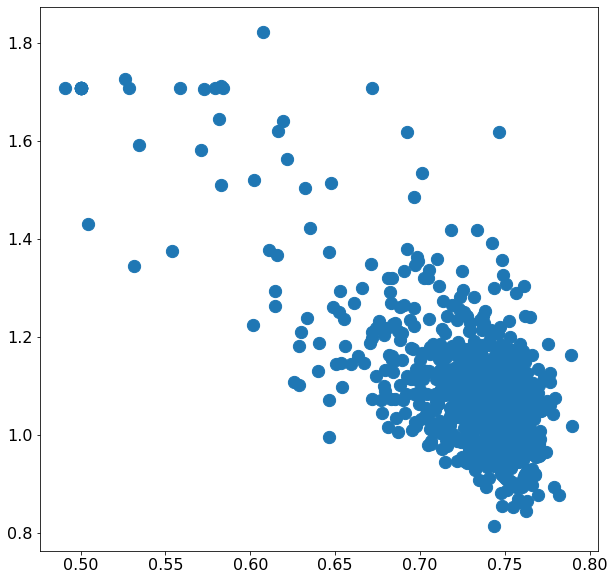

In [149]:
f_accs = []
f_scores = []
f_scores_scaled = []
sel_mats = []
sel_scores = []
sel_losses = []
sel_inds = []

ideal = np.concatenate((np.ones((16, 16)), np.zeros((16, 16)), np.zeros((16, 16)), np.zeros((16, 16))))
ideal_2 = np.concatenate((np.zeros((16, 16)), np.ones((16, 16)), np.zeros((16, 16)), np.zeros((16, 16))))
ideal = np.concatenate((ideal, ideal_2, ideal_2[::-1, :], ideal[::-1, :]), 1)

scaling = (np.ones((64, 64)) / 3) + (2 * ideal / 3)

# scores = (4096 - np.genfromtxt('./experiment_data/fmnist_4/trained_circuits/d2_mean_t_mat_scores.txt')) / 4096

for i in range(1000):
    curr_dir = './experiment_data/mnist_4/trained_circuits/circ_{}/'.format(i + 1)
    
    if os.path.exists(curr_dir + 'accs.txt'):
#         print(np.genfromtxt(curr_dir + 'accs.txt'))
        f_accs.append(np.mean(np.genfromtxt(curr_dir + 'val_losses.txt')))
#         f_scores.append(scores[i])
    
        curr_mat = np.genfromtxt(curr_dir + 'fid_mats/mean_t_mat.txt')
        diff_mat = curr_mat - ideal
        diff_scores = np.multiply(diff_mat, diff_mat)
        diff_scores_scaled = np.multiply(scaling, diff_scores)
        f_scores_scaled.append(np.sum(diff_scores_scaled))
        f_scores.append(np.sum(diff_scores))
        
        sel_mats.append(np.genfromtxt(curr_dir + 'fid_mats/mean_t_mat.txt'))
#         sel_scores.append(scores[i])
        sel_losses.append(f_accs[-1])
        sel_inds.append(i)
    
f_scores_scaled = (2048 - np.array(f_scores_scaled)) / 2048
f_scores = (4096 - np.array(f_scores)) / 4096
        
print(len(f_accs))
        
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# ax.hist(f_accs, bins=[0.05 * i for i in range(18)])
ax.scatter(f_scores_scaled, f_accs, s=150)
# ax.sctter(f_scores, f_accs)
# ax.scatter((2048 - np.array(f_scores_scaled)) / 2048, f_accs)

# print(scipy.stats.spearmanr(f_scores, f_accs))

In [91]:
print(scipy.stats.spearmanr(f_scores, f_accs))
print(scipy.stats.spearmanr(f_scores_scaled, f_accs))

SpearmanrResult(correlation=-0.37957825845956833, pvalue=4.520280644489564e-33)
SpearmanrResult(correlation=-0.4615126941986586, pvalue=5.587216512667759e-50)


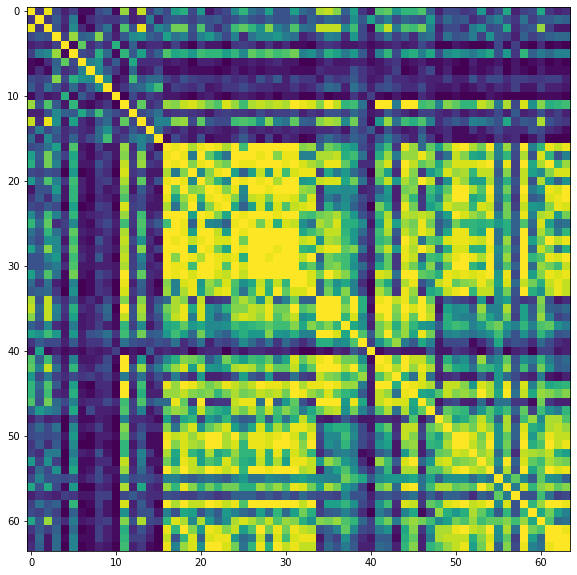

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.imshow(sel_mats[np.argmin(f_accs)])

## Finalize metric

In [15]:
datasets = ['moons_300', 'bank', 'mnist_2', 'fmnist_4']
trained_dir = 'trained_circuits'
filename_extras = ['_32_32', '', '', '_64_32_2']

# d2_min_scores = np.genfromtxt('./experiment_data/{}/{}/d2_min_scores{}.txt'.format(dataset, trained_dir, filename_extra))
# d2_mean_scores = np.genfromtxt('./experiment_data/{}/{}/d2_mean_scores{}.txt'.format(dataset, trained_dir, filename_extra))
# d2_var_scores = np.genfromtxt('./experiment_data/{}/{}/d2_var_scores{}.txt'.format(dataset, trained_dir, filename_extra))
# d2_t_min_scores = np.genfromtxt('./experiment_data/{}/{}/d2_t_min_scores{}.txt'.format(dataset, trained_dir, filename_extra))
# d2_t_mean_scores = np.genfromtxt('./experiment_data/{}/{}/d2_t_mean_scores{}.txt'.format(dataset, trained_dir, filename_extra))
# d2_t_var_scores = np.genfromtxt('./experiment_data/{}/{}/d2_t_var_scores{}.txt'.format(dataset, trained_dir, filename_extra))
mean_mat_scores = [np.genfromtxt('./experiment_data/{}/{}/d2_mean_mat_scores{}.txt'.format(datasets[i], trained_dir, filename_extras[i])) for i in range(len(datasets))]
mean_t_mat_scores = [np.genfromtxt('./experiment_data/{}/{}/d2_mean_t_mat_scores{}.txt'.format(datasets[i], trained_dir, filename_extras[i])) for i in range(len(datasets))]

accs = []
losses = []

for i in range(len(datasets)):
    curr_accs = []
    curr_losses = []
    
    for j in range(1000):
        curr_dir = './experiment_data/{}/{}/circ_{}'.format(datasets[i], trained_dir, j + 1)

        circ_accs = []
        circ_losses = []

        if os.path.exists(curr_dir + '/accs.txt'):
            circ_accs.append(np.genfromtxt(curr_dir + '/accs.txt'))

        if os.path.exists(curr_dir + '/val_losses.txt'):
            circ_losses.append(np.genfromtxt(curr_dir + '/val_losses.txt').flatten())

        for k in range(1, 2):
            if os.path.exists(curr_dir + '/accs_{}.txt'.format(k + 1)):
                circ_accs.append(np.genfromtxt(curr_dir + '/accs_{}.txt'.format(k + 1)))

            if os.path.exists(curr_dir + '/val_losses_{}.txt'.format(k + 1)):
                circ_losses.append(np.genfromtxt(curr_dir + '/val_losses_{}.txt'.format(k + 1)).flatten())

        circ_accs = np.mean(np.concatenate(circ_accs))
        circ_losses = np.mean(np.concatenate(circ_losses))

        curr_accs.append(circ_accs)
        curr_losses.append(circ_losses)

    accs.append(curr_accs)
    losses.append(curr_losses)

    print(i)

0
1
2
3


In [765]:
np.savetxt('./experiment_data/mnist_2/trained_circuits/accs.txt', accs)
np.savetxt('./experiment_data/mnist_2/trained_circuits/val_losses.txt', losses)

## Plot correlation graphs

(4, 1000)


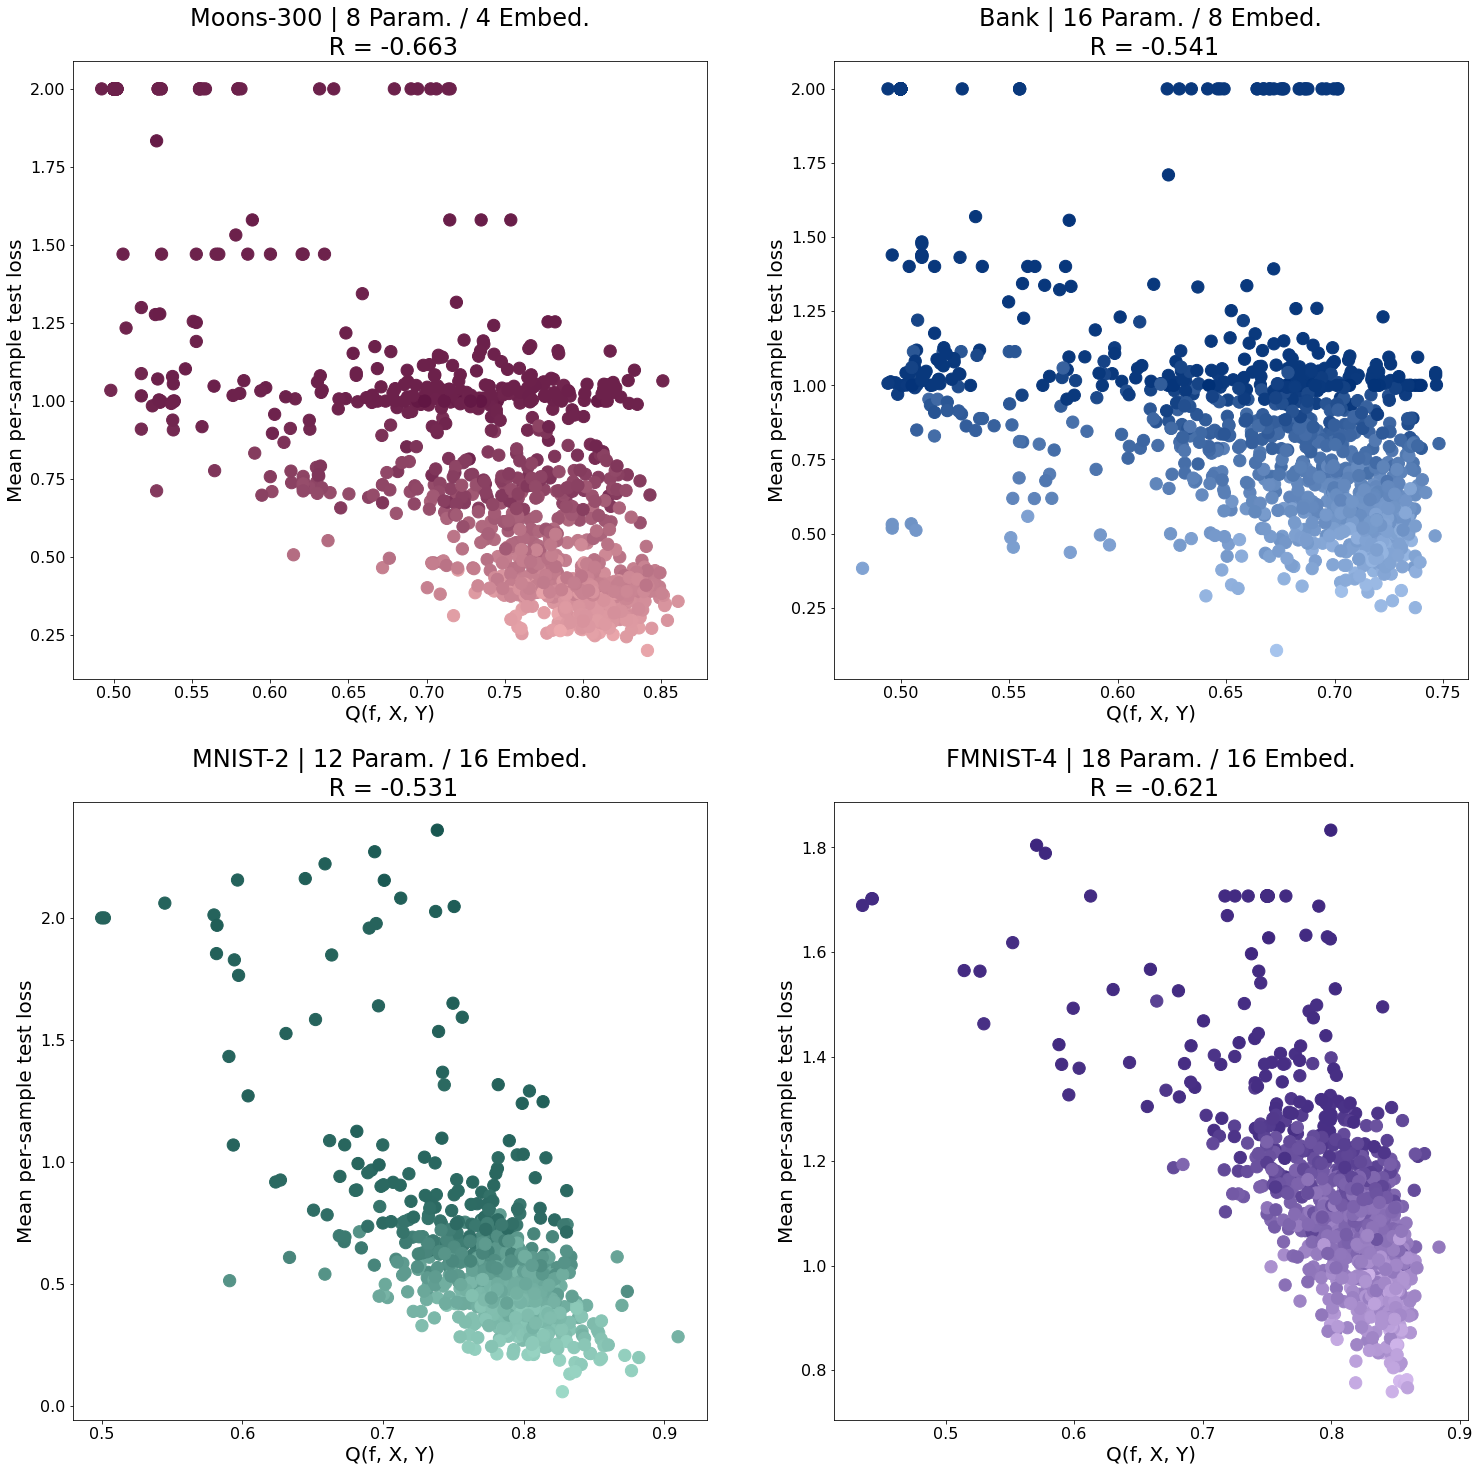

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(25, 25))

plt.rc('font', size=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

color_inds= [0, 1, 3, 5]

mat_sizes = [1024, 1024, 1024, 4096]
acc_bounds = [0.65, 0.55, 0.7, 0.4]

titles = ['Moons-300 | 8 Param. / 4 Embed.\n R = {}',
         'Bank | 16 Param. / 8 Embed.\n R = {}',
         'MNIST-2 | 12 Param. / 16 Embed.\n R = {}',
         'FMNIST-4 | 18 Param. / 16 Embed.\n R = {}']

num_plots = len(mat_sizes)

modified_scores = [(mat_sizes[i] - mean_t_mat_scores[i]) / mat_sizes[i] for i in range(num_plots)]

accs = np.array(accs)
losses = np.array(losses)

modified_accs = np.array([np.clip(accs[i], 0, acc_bounds[i]) * 0.2 + np.clip(accs[i] - acc_bounds[i], 0, 10) * 2 for i in range(num_plots)])

scaled_accs = modified_accs - np.min(modified_accs, 1).reshape((num_plots, 1))
scaled_accs /= np.max(scaled_accs, 1).reshape((num_plots, 1))
scaled_accs *= 0.9

print(scaled_accs.shape)

theme = np.zeros((8, 2, 3))
theme[0] = np.array([[252, 186, 185], [96, 20, 66]]) # pink
theme[1] = np.array([[184, 212, 250], [0, 48, 118]]) # blue
theme[2] = np.array([[255, 171, 181], [103, 2, 12]]) # red
theme[3] = np.array([[171, 231, 212], [24, 86, 80]]) # turqiose
theme[4] = np.array([[240, 219, 142], [123, 99, 0]]) # yellow
theme[5] = np.array([[228, 200, 249], [61, 37, 125]]) # purple
theme[6] = np.array([[247, 190, 159], [136, 46, 8]]) # orange
theme[7] = np.array([[184, 237, 155], [26, 77, 2]]) # green

colors = np.zeros((num_plots, len(losses[0]), 3))

for i in range(num_plots):
    colors[i, :, 0] = theme[color_inds[i], 0, 0] * scaled_accs[i] + theme[color_inds[i], 1, 0] * (1 - scaled_accs[i]) 
    colors[i, :, 1] = theme[color_inds[i], 0, 1] * scaled_accs[i] + theme[color_inds[i], 1, 1] * (1 - scaled_accs[i])
    colors[i, :, 2] = theme[color_inds[i], 0, 2] * scaled_accs[i] + theme[color_inds[i], 1, 2] * (1 - scaled_accs[i])

colors /= 255

for i in range(num_plots):
    ax[i // 2, i % 2].scatter(modified_scores[i], losses[i], s=150, c=colors[i])

    ax[i // 2, i % 2].set_xlabel('Q(f, X, Y)')
    ax[i // 2, i % 2].set_ylabel('Mean per-sample test loss')

    ax[i // 2, i % 2].set_title(titles[i].format(np.round(scipy.stats.spearmanr(modified_scores[i], losses[i])[0], 3)))
    # ax.set_title('Bank | 16 Param. / 8 Embed.\n R = {}\n'.format(np.round(scipy.stats.spearmanr(modified_scores, losses)[0], 3)))
    # ax.set_title('MNIST-2 | 12 Param. / 16 Embed.\n R = {}\n'.format(np.round(scipy.stats.spearmanr(modified_scores, losses)[0], 3)))
    # ax.set_title('FMNIST-4 | 18 Param. / 16 Embed.\n R = {}\n'.format(np.round(scipy.stats.spearmanr(modified_scores, losses)[0], 3)))

# scipy.stats.kendalltau(modified_scores, losses), scipy.stats.kendalltau(modified_scores, accs)

## Plot noisy correlation graphs

In [1332]:
noise_scores = []
act_tvd_scores = []
num_gates = []

losses = []
accs = []
accs_noiseless = []
losses_noiseless = []

num_params = []

sel_inds = []

dataset = 'mnist_4'
device_name = 'ibm_oslo'
trained_dir = 'trained_circuits'
filename_extra = ''

for i in range(1000):
    curr_dir = './experiment_data/{}/{}/circ_{}'.format(dataset, trained_dir, i + 1)
    
#     if os.path.exists(curr_dir + '/{}/val_losses_inference_only.npy'.format(device_name)):
    if os.path.exists(curr_dir + '/noise_metric/{}/actual_tvd_score.txt'.format(device_name)):
        noise_scores.append(np.genfromtxt(curr_dir + '/noise_metric/{}/metric_tvd_score.txt'.format(device_name)))
        act_tvd_scores.append(np.genfromtxt(curr_dir + '/noise_metric/{}/actual_tvd_score.txt'.format(device_name)))
        num_gates.append(len(np.genfromtxt(curr_dir + '/gates.txt')))
        
#         losses.append(np.mean(np.load(curr_dir + '/{}/val_losses_inference_only.npy'.format(device_name))))
        
#         accs_list = np.genfromtxt(curr_dir + '/{}/accs_inference_only.txt'.format(device_name))
        
#         accs.append(np.mean(accs_list))
        accs_noiseless.append(np.mean(np.genfromtxt(curr_dir + '/accs.txt')))
        losses_noiseless.append(np.mean(np.genfromtxt(curr_dir + '/val_losses.txt')))
        
        circ_gates, gate_params, inputs_bounds, weights_bounds = get_circ_params(curr_dir)
        num_params.append(weights_bounds[-1])
        
        sel_inds.append(i)
    else:
        print(i + 1)
        
# scores = (1024 - np.genfromtxt('./experiment_data/{}/{}/d2_mean_t_mat_scores{}.txt'.format(dataset, trained_dir, filename_extra))) / 1024
scores = (4096 - np.genfromtxt('./experiment_data/{}/{}/d2_mean_t_mat_scores{}.txt'.format(dataset, trained_dir, filename_extra))) / 4096
# accs_noiseless = np.genfromtxt('./experiment_data/{}/{}/accs.txt'.format(dataset, trained_dir))
# losses_noiseless = np.genfromtxt('./experiment_data/{}/{}/val_losses.txt'.format(dataset, trained_dir))

In [1321]:
len(accs_noiseless)

1000

Text(0, 0.5, 'Average Fidelity')

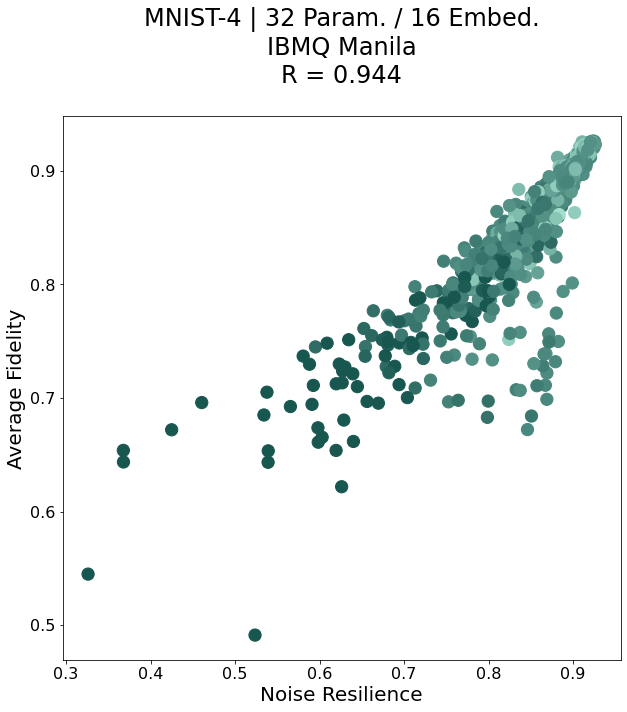

In [1322]:
device_names = ['ibmq_lima', 'ibmq_belem', 'ibmq_quito', 'ibmq_manila', 'ibm_nairobi', 'ibm_oslo']

accs_noiseless = np.array(accs_noiseless)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

plt.rc('font', size=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

num_gates = np.array(num_gates)

color_index = 3
device_num = 3

theme = np.zeros((8, 2, 3))
theme[0] = np.array([[252, 186, 185], [96, 20, 66]]) # pink
theme[1] = np.array([[184, 212, 250], [0, 48, 118]]) # blue
theme[2] = np.array([[255, 171, 181], [103, 2, 12]]) # red
theme[3] = np.array([[171, 231, 212], [24, 86, 80]]) # turqiose
theme[4] = np.array([[240, 219, 142], [123, 99, 0]]) # yellow
theme[5] = np.array([[228, 200, 249], [61, 37, 125]]) # purple
theme[6] = np.array([[247, 190, 159], [136, 46, 8]]) # orange
theme[7] = np.array([[184, 237, 155], [26, 77, 2]]) # green

# modified_accs = np.clip(num_gates, 0, 35) + np.clip(num_gates - 35, 0, 35) * 0.5 + np.clip(num_gates - 70, 0, 100) * 0.2
modified_accs = np.clip(num_gates, 0, np.quantile(num_gates, 0.25)) * 5 +\
            np.clip(num_gates - np.quantile(num_gates, 0.25), 0, np.quantile(num_gates, 0.85)) * 0.5

scaled_accs = modified_accs - np.min(modified_accs)
scaled_accs /= np.max(scaled_accs)
scaled_accs = 1 - scaled_accs

colors = np.zeros((len(scaled_accs), 3))
colors[:, 0] = theme[color_index, 0, 0] * scaled_accs + theme[color_index, 1, 0] * (1 - scaled_accs) 
colors[:, 1] = theme[color_index, 0, 1] * scaled_accs + theme[color_index, 1, 1] * (1 - scaled_accs)
colors[:, 2] = theme[color_index, 0, 2] * scaled_accs + theme[color_index, 1, 2] * (1 - scaled_accs)

colors /= 255

losses = np.array(losses)
losses_noiseless = np.array(losses_noiseless)
accs = np.array(accs)

ax.scatter(noise_scores, act_tvd_scores, c=colors, s=150)
# ax.scatter(noise_scores, losses_noiseless - losses, c=colors, s=150)

nice_device_str = device_names[device_num].split('_')[0].upper() + ' ' + device_names[device_num].split('_')[1].capitalize()

# ax.set_title('MNIST-2 | 12 Param. / 16 Embed.\n{}\nR = {}\n'.format(nice_device_str, np.round(scipy.stats.spearmanr(noise_scores, act_tvd_scores)[0], 3)))
# ax.set_title('FMNIST-4 | 18 Param. / 16 Embed.\n{}\nR = {}\n'.format(nice_device_str, np.round(scipy.stats.spearmanr(noise_scores, act_tvd_scores)[0], 3)))
ax.set_title('MNIST-4 | 32 Param. / 16 Embed.\n{}\nR = {}\n'.format(nice_device_str, np.round(scipy.stats.spearmanr(noise_scores, act_tvd_scores)[0], 3)))

ax.set_xlabel("Noise Resilience")
ax.set_ylabel("Average Fidelity")

# scipy.stats.spearmanr(noise_scores, losses_noiseless - losses)

(SpearmanrResult(correlation=-0.5726311210160693, pvalue=3.3959034277206505e-88),
 SpearmanrResult(correlation=0.5896350665085879, pvalue=1.1226447928806733e-94))

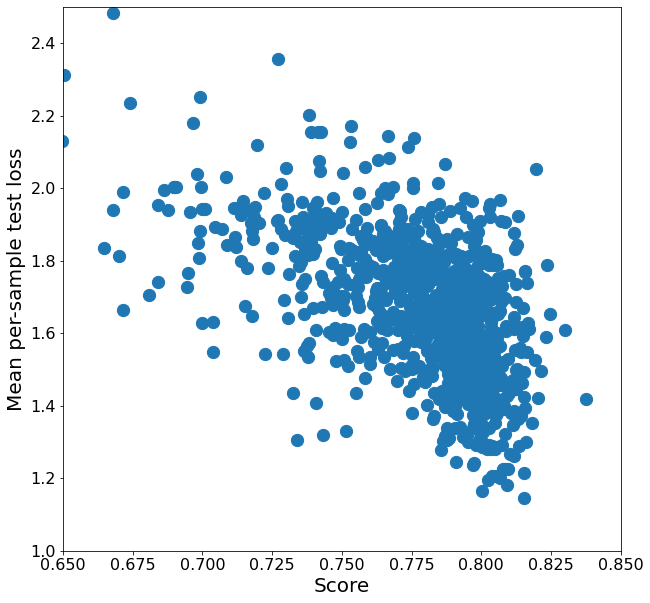

In [1328]:
device_names = ['ibmq_lima', 'ibmq_belem', 'ibmq_quito', 'ibmq_manila', 'ibm_nairobi', 'ibm_oslo']
combs = ['average', 'product', 'average rank']

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

plt.rc('font', size=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

color_index = 1
device_num = 3

noise_scores = np.array(noise_scores)
scores = np.array(scores)

combined_scores = np.multiply(np.power(noise_scores, 1), scores)

# accs = np.array(accs)
# losses = np.array(losses)

# modified_accs = np.clip(accs, 0, 0.65) * 0.2 + np.clip(accs - 0.65, 0, 10) * 2
# modified_accs = np.clip(accs, 0, 0.55) * 0.2 + np.clip(accs - 0.55, 0, 10) * 2
# modified_accs = np.clip(accs, 0, 0.75) * 0.2 + np.clip(accs - 0.75, 0, 10) * 2
# modified_accs = np.clip(accs, 0, 0.4) * 0.2 + np.clip(accs - 0.4, 0, 10) * 2

# scaled_accs = modified_accs - np.min(modified_accs)
# scaled_accs /= np.max(scaled_accs)

theme = np.zeros((8, 2, 3))
theme[0] = np.array([[252, 186, 185], [96, 20, 66]]) # pink
theme[1] = np.array([[184, 212, 250], [0, 48, 118]]) # blue
theme[2] = np.array([[255, 171, 181], [103, 2, 12]]) # red
theme[3] = np.array([[171, 231, 212], [24, 86, 80]]) # turqiose
theme[4] = np.array([[240, 219, 142], [123, 99, 0]]) # yellow
theme[5] = np.array([[228, 200, 249], [61, 37, 125]]) # purple
theme[6] = np.array([[247, 190, 159], [136, 46, 8]]) # orange
theme[7] = np.array([[184, 237, 155], [26, 77, 2]]) # green

# colors = np.zeros((len(losses), 3))
# colors[:, 0] = theme[color_index, 0, 0] * scaled_accs + theme[color_index, 1, 0] * (1 - scaled_accs) 
# colors[:, 1] = theme[color_index, 0, 1] * scaled_accs + theme[color_index, 1, 1] * (1 - scaled_accs)
# colors[:, 2] = theme[color_index, 0, 2] * scaled_accs + theme[color_index, 1, 2] * (1 - scaled_accs)

# colors /= 255

noise_ranks = np.argsort(noise_scores)

# ax.scatter(noise_scores[noise_ranks[:500]], losses[noise_ranks[:500]], s=150, c=colors)
ax.scatter(scores, losses_noiseless, s=150)

ax.set_ylim([1, 2.5])
ax.set_xlim([0.65, 0.85])

ax.set_xlabel('Score')
ax.set_ylabel('Mean per-sample test loss')

# ax.set_xlabel('Clifford Noise Resilience')
# ax.set_ylabel('Representation Capacity')

nice_device_str = device_names[device_num].split('_')[0].upper() + ' ' + device_names[device_num].split('_')[1].capitalize() + " (inference only)"

# ax.set_title('Moons-300 | 8 Param. / 4 Embed.\n{}\nR = {}\n'.format(device_name, np.round(scipy.stats.spearmanr(combined_scores, losses)[0], 3)))
# ax.set_title('Bank | 16 Param. / 8 Embed.\n{}\nR = {}\n'.format(device_name, np.round(scipy.stats.spearmanr(combined_scores, losses)[0], 3)))
# ax.set_title('MNIST-2 | 12 Param. / 16 Embed.\n{}\nR = {}\n'.format(nice_device_str, np.round(scipy.stats.spearmanr(combined_scores, losses)[0], 3)))
# ax.set_title('FMNIST-4 | 18 Param. / 16 Embed.\n{}\nR = {}\n'.format(nice_device_str, np.round(scipy.stats.spearmanr(combined_scores, losses)[0], 3)))

# ax.set_title('Combination method: {}\nR = {}\n'.format(combs[comb_index], np.round(scipy.stats.spearmanr(combined_scores, losses)[0], 3)))

# scipy.stats.kendalltau(noise_scores, losses - losses_noiseless), scipy.stats.kendalltau(combined_scores, losses)
scipy.stats.spearmanr(scores, losses_noiseless), scipy.stats.spearmanr(scores, accs_noiseless)

In [192]:
device_names = ['ibmq_lima', 'ibmq_belem', 'ibmq_quito', 'ibmq_manila', 'ibm_nairobi', 'ibm_oslo']
combs = ['Average', 'Product', 'Average Rank']

# fig, ax = plt.subplots(1, 3, figsize=(35, 10))

plt.rc('font', size=24)
plt.rc('axes', labelsize=24)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

color_index = [2, 3, 5]
device_num = 4

noise_scores = np.array(noise_scores)
scores = np.array(scores)

combined_scores_1 = (noise_scores + scores) * 0.5
combined_scores_2 = np.multiply(np.power(noise_scores, 1), scores)
combined_scores_3 = np.zeros(1000)
noise_ranks = np.argsort(noise_scores)
perf_ranks = np.argsort(scores)

for i in range(1000):
    combined_scores_3[noise_ranks[i]] += i
    combined_scores_3[perf_ranks[i]] += i
    
combined_scores_3 /= 2

combined_scores = [combined_scores_1, combined_scores_2, combined_scores_3]

accs = np.array(accs)
losses = np.array(losses)

# modified_accs = np.clip(accs, 0, 0.65) * 0.2 + np.clip(accs - 0.65, 0, 10) * 2
# modified_accs = np.clip(accs, 0, 0.55) * 0.2 + np.clip(accs - 0.55, 0, 10) * 2
# modified_accs = np.clip(accs, 0, 0.75) * 0.2 + np.clip(accs - 0.75, 0, 10) * 2
modified_accs = np.clip(accs, 0, 0.4) * 0.2 + np.clip(accs - 0.4, 0, 10) * 2

scaled_accs = modified_accs - np.min(modified_accs)
scaled_accs /= np.max(scaled_accs)

theme = np.zeros((8, 2, 3))
theme[0] = np.array([[252, 186, 185], [96, 20, 66]]) # pink
theme[1] = np.array([[184, 212, 250], [0, 48, 118]]) # blue
theme[2] = np.array([[255, 171, 181], [103, 2, 12]]) # red
theme[3] = np.array([[171, 231, 212], [24, 86, 80]]) # turqiose
theme[4] = np.array([[240, 219, 142], [123, 99, 0]]) # yellow
theme[5] = np.array([[228, 200, 249], [61, 37, 125]]) # purple
theme[6] = np.array([[247, 190, 159], [136, 46, 8]]) # orange
theme[7] = np.array([[184, 237, 155], [26, 77, 2]]) # green

for i in range(3):
#     colors = np.zeros((len(losses), 3))
#     colors[:, 0] = theme[color_index[i], 0, 0] * scaled_accs + theme[color_index[i], 1, 0] * (1 - scaled_accs) 
#     colors[:, 1] = theme[color_index[i], 0, 1] * scaled_accs + theme[color_index[i], 1, 1] * (1 - scaled_accs)
#     colors[:, 2] = theme[color_index[i], 0, 2] * scaled_accs + theme[color_index[i], 1, 2] * (1 - scaled_accs)

#     colors /= 255

    # ax.scatter(combined_scores, 0.5 * (noise_scores + scores), s=150, c=colors)
#     ax[i].scatter(combined_scores[i], losses, s=150, c=colors)

#     ax[i].set_xlabel('Combined Score')
#     ax[i].set_ylabel('Mean per-sample test loss')

#     # ax.set_xlabel('Clifford Noise Score')
#     # ax.set_ylabel('Clifford Noise + Representation Capacity Combined Score')

#     nice_device_str = device_names[device_num].split('_')[0].upper() + ' ' + device_names[device_num].split('_')[1].capitalize() + " (inference only)"

#     # ax.set_title('Moons-300 | 8 Param. / 4 Embed.\n{}\nR = {}\n'.format(device_name, np.round(scipy.stats.spearmanr(combined_scores, losses)[0], 3)))
#     # ax.set_title('Bank | 16 Param. / 8 Embed.\n{}\nR = {}\n'.format(device_name, np.round(scipy.stats.spearmanr(combined_scores, losses)[0], 3)))
#     # ax.set_title('MNIST-2 | 12 Param. / 16 Embed.\n{}\nR = {}\n'.format(nice_device_str, np.round(scipy.stats.spearmanr(combined_scores, losses)[0], 3)))
#     # ax.set_title('FMNIST-4 on {}\nCombination method: {}\nR = {}\n'.format(
#     #     nice_device_str, combs[comb_index], np.round(scipy.stats.spearmanr(combined_scores, losses)[0], 3)))

#     ax[i].set_title('{}\nR = {}\n'.format(combs[i], np.round(scipy.stats.spearmanr(combined_scores[i], losses)[0], 3)))
    print(np.round(scipy.stats.spearmanr(combined_scores[i], losses)[0], 3))

# scipy.stats.kendalltau(noise_scores, losses - losses_noiseless), scipy.stats.kendalltau(combined_scores, losses)

-0.486
-0.497
-0.468


## Draw Graphs 1 and 2

In [1338]:
plt.rc('font', size=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=16)

# fig, ax = plt.subplots(1, 1, figsize=(10, 10))

curr_dataset = 8

d_size = [480, 1022, 1600, 8000, 600, 600, 1600, 8000, 60000]
inf_size = [120, 122, 400, 2000, 120, 120, 400, 2000, 10000]
p = [16, 20, 20, 24, 32, 40, 32, 40, 100]

our_factors = [1, 1, 1, 2, 1, 2, 1, 2, 10]

theme = np.zeros((8, 2, 3))
theme[0] = np.array([[252, 186, 185], [96, 20, 66]]) # pink
theme[1] = np.array([[184, 212, 250], [0, 48, 118]]) # blue
theme[2] = np.array([[255, 171, 181], [103, 2, 12]]) # red
theme[3] = np.array([[171, 231, 212], [24, 86, 80]]) # turqiose
theme[4] = np.array([[240, 219, 142], [123, 99, 0]]) # yellow
theme[5] = np.array([[228, 200, 249], [61, 37, 125]]) # purple
theme[6] = np.array([[247, 190, 159], [136, 46, 8]]) # orange
theme[7] = np.array([[184, 237, 155], [26, 77, 2]]) # green

theme /= 255

ours = 1024

legend = ['Ours (N = 100)', 'Ours (N = 250)', 'Ours (N = 500)', 'Ours (N = 1000)', 'Supernet (T = 100)', 'Supernet (T = 250)', 'Supernet (T = 500)', 'Supernet (T = 1000)']

init_bar_labels = [i for i in range(4)] + [5 + i for i in range(4)]
vals = []

for i in range(curr_dataset, curr_dataset + 1):
    vals += [j * 256 + ours * 0.5 * j * our_factors[i] for j in [250, 500, 1000, 100]]

for i in range(curr_dataset, curr_dataset + 1):
    vals += [inf_size[i] * 3000 + d_size[i] * (2 * p[i]) * j for j in [200, 400, 250, 500]]

# colors = [theme[i][1] for i in range(4)] + [theme[i][0] for i in range(4)]

# for i in range(len(legend)):
#     ax.bar([init_bar_labels[i]], [vals[i]], width=1, color=colors[i], label=legend[i])

# ax.set_xticks([1.5, 6.5], ['Ours', 'Supernet'])

# ax.set_ylabel("Number of circuit runs")

# titles = ["Moons-300 | 16 Parameters", "Bank | 20 Parameters", "MNIST-2 | 20 Parameters", "FMNIST-4 | 24 Parameters", "MNIST-10 | 160 Parameters"]

# ax.set_title(titles[curr_dataset])

# ax.legend()
# ax.set_yscale('log')

print('us vs quantumNAS: ', vals[4] / vals[3])
print('us vs quantumsupernet: ', (vals[5] - inf_size[i] * 2900) / vals[3])

us vs quantumNAS:  4520.089285714285
us vs quantumsupernet:  8930.431547619048


In [548]:
total = 646.875 + 182.291 + 111.229 + 44.68

(total / 4) / 1.5

164.17916666666665

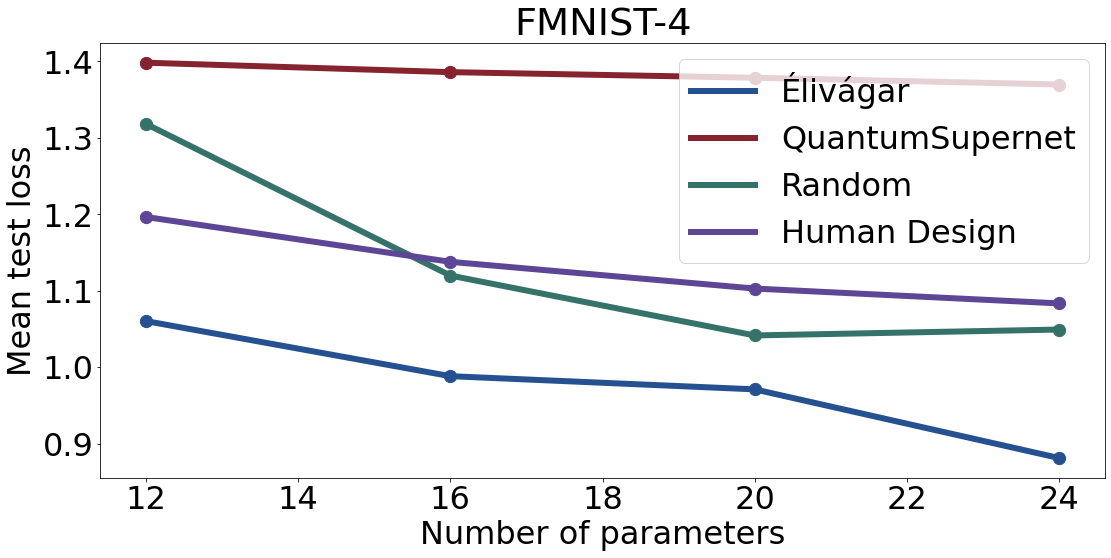

In [529]:
plt.rc('font', size=32)
plt.rc('axes', labelsize=32)
plt.rc('xtick', labelsize=32)
plt.rc('ytick', labelsize=32)

dataset = 'fmnist_4'

fig, ax = plt.subplots(1, 1, figsize=(18, 8))

# param_nums = [2, 4, 6, 8, 10, 12, 14, 16]
# param_nums = [4, 8, 12, 16, 20]
param_nums = [12, 16, 20, 24]

rand_accs = []
all_accs = []
supernet_mb_accs = []
hd_accs = []
hd_accs_2 = []
hd_accs_3 = []
    
for i in param_nums:
    curr_accs = []

    for j in range(25):
        curr_accs.append(np.genfromtxt('./ours/{}/{}_params/search_100/trial_{}/val_losses.txt'.format(dataset, i, device_name, j + 1)))

    all_accs.append(np.mean(curr_accs))

for i in param_nums:
    curr_accs = []

    for j in range(25):
        curr_accs.append(np.genfromtxt('./random/{}/{}_params/circ_{}/val_losses.txt'.format(dataset, i, j + 1)))

    rand_accs.append(np.mean(curr_accs))
    
for i in param_nums:
    curr_accs = []

    for j in range(25):
        curr_accs.append(np.genfromtxt('./supernet/{}/search-{}_params_mb/search_100/trial_{}/val_losses.txt'.format(dataset, i, j + 1)))

    supernet_mb_accs.append(np.mean(curr_accs))
    
for i in param_nums:
    curr_accs = []

    for j in range(1):
        curr_accs.append(np.genfromtxt('./human_design/angle_basic/{}/{}_params/val_losses.txt'.format(dataset, i, j + 1)))

    hd_accs.append(np.mean(curr_accs))
    
for i in param_nums:
    curr_accs = []

    for j in range(1):
        curr_accs.append(np.genfromtxt('./human_design/iqp_basic/{}/{}_params/val_losses.txt'.format(dataset, i, j + 1)))

    hd_accs_2.append(np.mean(curr_accs))
    
for i in param_nums:
    curr_accs = []

    for j in range(1):
        curr_accs.append(np.genfromtxt('./human_design/amp_basic/{}/{}_params/val_losses.txt'.format(dataset, i, j + 1)))

    hd_accs_3.append(np.mean(curr_accs))

hd_mean_accs = np.mean(np.concatenate((hd_accs, hd_accs_2, hd_accs_3)).reshape((3, len(hd_accs))), 0)

# theme = np.zeros((5, 2, 3))
# theme[0] = np.array([[238, 246, 252], [9, 43, 93]]) # blue
# theme[1] = np.array([[252, 232, 236], [74, 36, 55]]) # red
# theme[2] = np.array([[220, 241, 239], [24, 86, 80]]) # green
# theme[3] = np.array([[242, 226, 254], [61, 37, 125]]) # purple
# theme[4] = np.array([[255, 242, 235], [125, 46, 13]]) # orange

theme = np.zeros((8, 2, 3))
theme[0] = np.array([[252, 186, 185], [96, 20, 66]]) # pink
theme[1] = np.array([[184, 212, 250], [0, 48, 118]]) # blue
theme[2] = np.array([[255, 171, 181], [103, 2, 12]]) # red
theme[3] = np.array([[171, 231, 212], [24, 86, 80]]) # turqiose
theme[4] = np.array([[240, 219, 142], [123, 99, 0]]) # yellow
theme[5] = np.array([[228, 200, 249], [61, 37, 125]]) # purple
theme[6] = np.array([[247, 190, 159], [136, 46, 8]]) # orange
theme[7] = np.array([[184, 237, 155], [26, 77, 2]]) # green

theme_avg = 0.2 * theme[:, 0] + 0.8 * theme[:, 1]

theme_avg /= 255
# ax.plot(param_nums, all_accs, label="ours")
# ax.plot(param_nums, our_fe_accs, label="ours + angle")
# ax.plot(param_nums, our_fe_accs_2, label="ours + iqp")
# ax.plot(param_nums, supernet_accs, label="supernet")
# ax.plot(param_nums, rand_accs, label="random")
# ax.plot(param_nums, rand_fe_accs, label="random + angle")
# ax.plot(param_nums, rand_fe_accs_2, label="random + iqp")
# ax.plot(param_nums, hd_accs, label="hd + angle")
# ax.plot(param_nums, hd_accs_2, label="hd + iqp")
# ax.plot(param_nums, hd_accs_3, label="hd + amp")
# ax.plot(param_nums, hd_mean_accs, label="human design")

ax.plot(param_nums, all_accs, linewidth=6, label="Élivágar", c=theme_avg[1])
ax.plot(param_nums, supernet_mb_accs, linewidth=6, label="QuantumSupernet", c=theme_avg[2])
ax.plot(param_nums, rand_accs, linewidth=6, label="Random", c=theme_avg[3])
ax.plot(param_nums, hd_mean_accs, linewidth=6, label="Human Design", c=theme_avg[5])

ax.scatter(param_nums, all_accs, color=theme_avg[1], s=150)
ax.scatter(param_nums, supernet_mb_accs, color=theme_avg[2], s=150)
ax.scatter(param_nums, rand_accs, color=theme_avg[3], s=150)
ax.scatter(param_nums, hd_mean_accs, color=theme_avg[5], s=150)

# ax.set_title('Moons-300')
# ax.set_title('Bank')
# ax.set_title('MNIST-2')
ax.set_title('FMNIST-4')

ax.set_xlabel('Number of parameters')
ax.set_ylabel('Mean test loss')

ax.legend()

## Draw graph 3 (noisy graph 1)

In [ ]:
plt.rc('font', size=32)
plt.rc('axes', labelsize=32)
plt.rc('xtick', labelsize=32)
plt.rc('ytick', labelsize=32)

dataset = 'fmnist_4'

device_name = 'ibm_nairobi'

fig, ax = plt.subplots(1, 1, figsize=(18, 8))

# param_nums = [2, 4, 6, 8, 10, 12, 14, 16]
# param_nums = [4, 8, 12, 16, 20]
param_nums = [12, 16, 20, 24]

rand_accs = []
all_accs = []
supernet_mb_accs = []
hd_accs = []
hd_accs_2 = []
hd_accs_3 = []
    
for i in param_nums:
    curr_accs = []

    for j in range(25):
        curr_accs.append(np.genfromtxt('./ours/{}/{}_params/search_100{}/trial_{}/noisy_val_losses.txt'.format(dataset, i, '_' + device_name, j + 1)))
#         curr_accs.append(np.load('./ours/{}/{}_params/search_100{}/trial_{}/noisy_val_losses.txt.npy'.format(dataset, i, '_' + device_name, j + 1)))

    all_accs.append(np.mean(curr_accs))

for i in param_nums:
    curr_accs = []

    for j in range(25):
        curr_accs.append(np.load('./random/{}/{}_params/circ_{}/{}/val_losses_inference_only.npy'.format(dataset, i, j + 1, device_name)))

    rand_accs.append(np.mean(curr_accs))
    
for i in param_nums:
    curr_accs = []

    for j in range(25):
        curr_accs.append(np.genfromtxt('./supernet/{}/search-{}_params_mb/{}/search_100/trial_{}/noisy_val_losses.txt'.format(dataset, i, device_name, j + 1)))

    supernet_mb_accs.append(np.mean(curr_accs))
    
for i in param_nums:
    curr_accs = []

    for j in range(1):
        curr_accs.append(np.load('./human_design/angle_basic/{}/{}_params/{}/val_losses_inference_only.npy'.format(dataset, i, device_name)))

    hd_accs.append(np.mean(curr_accs))
    
for i in param_nums:
    curr_accs = []

    for j in range(1):
        curr_accs.append(np.load('./human_design/iqp_basic/{}/{}_params/{}/val_losses_inference_only.npy'.format(dataset, i, device_name)))

    hd_accs_2.append(np.mean(curr_accs))
    
for i in param_nums:
    curr_accs = []

    for j in range(1):
        curr_accs.append(np.load('./human_design/amp_basic/{}/{}_params/{}/val_losses_inference_only.npy'.format(dataset, i, device_name)))

    hd_accs_3.append(np.mean(curr_accs))

hd_mean_accs = np.mean(np.concatenate((hd_accs, hd_accs_2, hd_accs_3)).reshape((3, len(hd_accs))), 0)

theme = np.zeros((8, 2, 3))
theme[0] = np.array([[252, 186, 185], [96, 20, 66]]) # pink
theme[1] = np.array([[184, 212, 250], [0, 48, 118]]) # blue
theme[2] = np.array([[255, 171, 181], [103, 2, 12]]) # red
theme[3] = np.array([[171, 231, 212], [24, 86, 80]]) # turqiose
theme[4] = np.array([[240, 219, 142], [123, 99, 0]]) # yellow
theme[5] = np.array([[228, 200, 249], [61, 37, 125]]) # purple
theme[6] = np.array([[247, 190, 159], [136, 46, 8]]) # orange
theme[7] = np.array([[184, 237, 155], [26, 77, 2]]) # green

theme_avg = 0.2 * theme[:, 0] + 0.8 * theme[:, 1]

theme_avg /= 255

ax.plot(param_nums, all_accs, linewidth=6, label="Élivágar", c=theme_avg[1])
ax.plot(param_nums, supernet_mb_accs, linewidth=6, label="QuantumSupernet", c=theme_avg[2])
ax.plot(param_nums, rand_accs, linewidth=6, label="Random", c=theme_avg[3])
# ax.plot(param_nums, hd_mean_accs, linewidth=6, label="Human Design", c=theme_avg[5])
ax.plot(param_nums, hd_accs, linewidth=6, label="Human Design", c=theme_avg[5])

ax.scatter(param_nums, all_accs, color=theme_avg[1], s=150)
ax.scatter(param_nums, supernet_mb_accs, color=theme_avg[2], s=150)
ax.scatter(param_nums, rand_accs, color=theme_avg[3], s=150)
# ax.scatter(param_nums, hd_mean_accs, color=theme_avg[5], s=150)
ax.scatter(param_nums, hd_accs, color=theme_avg[5], s=150)

nice_device_str = device_name.split('_')[0].upper() + ' ' + device_name.split('_')[1].capitalize()

# ax.set_title('Moons-300 on {}'.format(nice_device_str))
# ax.set_title('Bank on {}'.format(nice_device_str))
# ax.set_title('MNIST-2 on {}'.format(nice_device_str))
ax.set_title('FMNIST-4 on {}'.format(nice_device_str))

ax.set_xlabel('Number of parameters')
ax.set_ylabel('Mean test loss')

ax.legend()

## Plot noise correlation graphs

In [113]:
noise_scores = [[] for i in range(6)]
fids = [[] for i in range(6)]

device_names = ['ibmq_lima', 'ibmq_belem', 'ibmq_quito', 'ibmq_manila', 'ibm_nairobi', 'ibm_oslo']

for i in range(1000):
    for j in range(6):
        circ_dir = './experiment_data/noise_metric/circ_{}/noise_metric/{}'.format(i + 1, device_names[j])

        fids[j].append(np.genfromtxt(circ_dir + '/avg_tvd.txt').item())
        noise_scores[j].append(np.genfromtxt(circ_dir + '/tvd_metric_score.txt').item())
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [114]:
modified_scores = 1 - np.mean(np.array(fids), 0)

modified_scores = np.clip(modified_scores, 0, 0.63) * 0.3 + np.clip(modified_scores - 0.63, 0, 1) * 2

modified_scores -= np.min(modified_scores)
modified_scores /= np.max(modified_scores)

fids = np.array(fids)
noise_scores = np.array(noise_scores)

Text(0, 0.5, 'Average Fidelity')

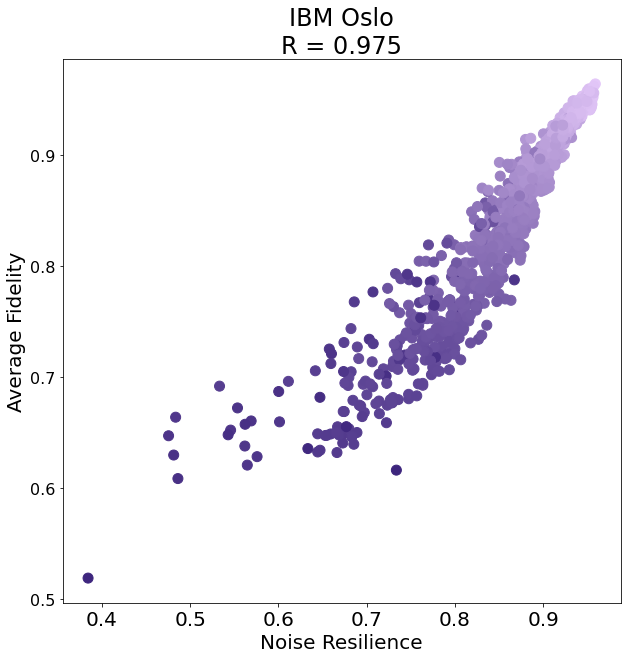

In [124]:
plt.rc('font', size=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=16)

device_num = 5
color_num = 5

theme = np.zeros((8, 2, 3))
theme[0] = np.array([[252, 186, 185], [96, 20, 66]]) # pink
theme[1] = np.array([[184, 212, 250], [0, 48, 118]]) # blue
theme[2] = np.array([[255, 171, 181], [103, 2, 12]]) # red
theme[3] = np.array([[171, 231, 212], [24, 86, 80]]) # turqiose
theme[4] = np.array([[240, 219, 142], [123, 99, 0]]) # yellow
theme[5] = np.array([[228, 200, 249], [61, 37, 125]]) # purple
theme[6] = np.array([[247, 190, 159], [136, 46, 8]]) # orange
theme[7] = np.array([[184, 237, 155], [26, 77, 2]]) # green


theme /= 255

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

colors = np.zeros((len(noise_scores[device_num]), 3))
colors[:, 0] = theme[color_num, 0, 0] * modified_scores + theme[color_num, 1, 0] * (1 - modified_scores) 
colors[:, 1] = theme[color_num, 0, 1] * modified_scores + theme[color_num, 1, 1] * (1 - modified_scores)
colors[:, 2] = theme[color_num, 0, 2] * modified_scores + theme[color_num, 1, 2] * (1 - modified_scores)

ax.scatter(1 - noise_scores[device_num], 1 - fids[device_num], s=100, c=colors)

ax.set_title(device_names[device_num].split('_')[0].upper() + ' ' + device_names[device_num].split('_')[1].capitalize() +\
             '\nR = {}'.format(np.round(scipy.stats.spearmanr(1 - noise_scores[device_num], 1 - fids[device_num])[0], 3)))

ax.set_xlabel("Noise Resilience")
ax.set_ylabel("Average Fidelity")

In [92]:
from create_gate_circs import create_batched_gate_circ, get_circ_params
from metrics import compute_reduced_similarity
from datasets import load_dataset

ideal = np.concatenate((np.ones((64, 64)), np.zeros((64, 64))))
ideal = np.concatenate((ideal, ideal[::-1, :]), 1)

curr_dir = './experiment_data/mnist_2/trained_circuits'
num_qubits = 4
meas_qubits = [0]

ind = 68

num_params = 32
num_data = 256

x_train, y_train, x_test, y_test = load_dataset('mnist_2', 'angle', 2)

class_0_sel = np.random.choice(800, num_data // 2, False)
class_1_sel = np.random.choice(800, num_data // 2, False) + 800
sel_inds = np.concatenate((class_0_sel, class_1_sel))

sel_data = x_train[sel_inds]

all_mats = []

for k in all_inds:
    circ_dir = curr_dir + '/circ_{}'.format(k + 1)
    circ_gates, gate_params, inputs_bounds, weights_bounds = get_circ_params(circ_dir)

    batched_circ = create_batched_gate_circ(qml.device('lightning.qubit', wires=num_qubits), circ_gates, gate_params, inputs_bounds,
                                            weights_bounds, meas_qubits, 'matrix') 

    params = 2 * np.pi * np.random.sample((num_params, weights_bounds[-1]))

    circ_t_mean_mat = np.zeros((num_data, num_data))

    for j in range(num_params):
        curr_params = np.concatenate([params[j] for k in range(num_data)]).reshape((num_data, weights_bounds[-1]))
        mat = compute_reduced_similarity(batched_circ, curr_params, sel_data)

        t_mat = mat > ((np.sum(mat) - num_data) / (num_data * (num_data - 1)))

        circ_t_mean_mat += t_mat / num_params
        
    all_mats.append(circ_t_mean_mat)
    
    print(k)

115
67
72
38
97
615
636
491
949
809
290
834
472
779
117
330
287
629
545
402
657
238
845
756
215


In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(50, 50))

theme = np.array([[184, 212, 250], [0, 48, 118]]) # blue
theme = np.array([[255, 255, 255], [0, 48, 118]]) # blue
theme = theme / 255

c_img = np.zeros((num_data, num_data, 3))

for i in range(25):
    c_img[:, :, 0] = (all_mats[i] ** 2) * theme[1, 0] + (1 - (all_mats[i] ** 2)) * theme[0, 0]
    c_img[:, :, 1] = (all_mats[i] ** 2) * theme[1, 1] + (1 - (all_mats[i] ** 2)) * theme[0, 1]
    c_img[:, :, 2] = (all_mats[i] ** 2) * theme[1, 2] + (1 - (all_mats[i] ** 2)) * theme[0, 2]

    ax[i % 5, i // 5].imshow(c_img)

    ax[i % 5, i // 5].set_xticks([])
    ax[i % 5, i // 5].set_yticks([])

## genreate circuits

In [243]:
f = open('./experiment_data/moons_300/trained_circuits_varied/notes.txt', 'w')

f.write('Search Space Params:\nNum Data Reuploads: [1, 3]\nNum Params: [8, 20]')

f.close()

In [16]:
from create_gate_circs import generate_random_gate_circ, generate_true_random_gate_circ

num_qubits = 4
num_embeds = 16

curr_dir = './random/mnist_4/'

base_params = 24

if not os.path.exists(curr_dir):
    os.mkdir(curr_dir)

for i in range(5):
    num_params = base_params + 4 * i
    
    curr_param_dir = curr_dir + '{}_params'.format(num_params)

    if not os.path.exists(curr_param_dir):
        os.mkdir(curr_param_dir)
    
    for j in range(25):
        curr_circ_dir = curr_param_dir + f'/circ_{j + 1}'
        
        if not os.path.exists(curr_circ_dir):
            os.mkdir(curr_circ_dir)
        
        ent_prob = np.random.sample()
        cxz = np.random.sample()
        pauli = 0

        circ_gates, gate_params, inputs_bounds, weights_bounds = generate_true_random_gate_circ(num_qubits, num_embeds, num_params, 
                                                                                                            ent_prob=ent_prob, 
                                                                                                            cxz_prob=cxz * ent_prob,
                                                                                                            pauli_prob=pauli * (
                                                                                                                1 - cxz) * ent_prob)

        np.savetxt(curr_circ_dir + '/gates.txt', circ_gates, fmt="%s")
        np.savetxt(curr_circ_dir + '/gate_params.txt', gate_params, fmt="%s")
        np.savetxt(curr_circ_dir + '/inputs_bounds.txt', inputs_bounds)
        np.savetxt(curr_circ_dir + '/weights_bounds.txt', weights_bounds)

In [174]:
for i in range(1000):
    for j in range(6):
        circ_dir = './experiment_data/noise_metric/circ_{}/noise_metric/{}'.format(i + 1, device_names[j])
        
        noisy_dists = np.genfromtxt(circ_dir + '/noisy_dists.txt')
        noiseless_dists = np.genfromtxt(circ_dir + '/noiseless_dists.txt')
        
        tvds = 0.5 * np.sum(np.abs(noisy_dists - noiseless_dists), 1)
        
        np.savetxt(circ_dir + '/tvds.txt', tvds)
        np.savetxt(circ_dir + '/avg_tvd.txt', [np.mean(tvds)])
        
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## motivting examples for paper

In [472]:
x = np.linspace(0, 2 * np.pi, 100)
y = -0.75 * np.sin(2 * x) + 0.05

theme = np.zeros((8, 2, 3))
theme[0] = np.array([[252, 186, 185], [96, 20, 66]]) # pink
theme[1] = np.array([[184, 212, 250], [0, 48, 118]]) # blue
theme[2] = np.array([[184, 237, 155], [26, 77, 2]]) # green

theme /= 255

plt.rc('font', size=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=16)

In [473]:
from create_gate_circs import create_gate_circ
from train_circ import train_qnn, mse_loss

circ_gates = ['rot', 'rx', 'rot']
gate_params = [[0], [0], [0]]
inputs_bounds = [0, 0, 1, 1]
weights_bounds = [0, 3, 3, 6]

x = x.reshape(len(x), 1)

circ_1 = create_gate_circ(qml.device('lightning.qubit', wires=1), circ_gates, gate_params, inputs_bounds, weights_bounds, [0], 'exp')

info_1 = train_qnn(circ_1, x, y, [], [], [weights_bounds[-1]], 1000, 0.05, 1, mse_loss, verbosity=7300, 
                                                                                        loss_window=50, init_params=None, 
                                                                                        acc_thres=1.1, shuffle=True, print_loss=50)

Step 1 | Sliding Loss Window : 0.1149739568744816
Step 51 | Sliding Loss Window : 0.33598500683824745
Step 101 | Sliding Loss Window : 0.3386065402340943
Step 151 | Sliding Loss Window : 0.26402365913641845
Step 201 | Sliding Loss Window : 0.33664375462174617
Step 251 | Sliding Loss Window : 0.26469222211794835
Step 301 | Sliding Loss Window : 0.3354347308747676
Step 351 | Sliding Loss Window : 0.26576313506188626
Step 401 | Sliding Loss Window : 0.33510240626006826
Step 451 | Sliding Loss Window : 0.2665342297412745
Step 501 | Sliding Loss Window : 0.3349862468826635
Step 551 | Sliding Loss Window : 0.2671959061680462
Step 601 | Sliding Loss Window : 0.33489105198111885
Step 651 | Sliding Loss Window : 0.2678114501434292
Step 701 | Sliding Loss Window : 0.3347836440120843
Step 751 | Sliding Loss Window : 0.26839728891052295
Step 801 | Sliding Loss Window : 0.33466418941899706
Step 851 | Sliding Loss Window : 0.2689632069728597
Step 901 | Sliding Loss Window : 0.33453689644018136
Step 

In [474]:
from create_gate_circs import create_gate_circ
from train_circ import train_qnn, mse_loss

circ_gates = ['rot', 'rx', 'rot', 'ry']
gate_params = [[0], [0], [0], [0]]
inputs_bounds = [0, 0, 1, 1, 2]
weights_bounds = [0, 3, 3, 6, 6]

x = x.reshape(len(x), 1)
d_x = np.concatenate((x, x), 1)

circ_2 = create_gate_circ(qml.device('lightning.qubit', wires=1), circ_gates, gate_params, inputs_bounds, weights_bounds, [0], 'exp')

info_2 = train_qnn(circ_2, d_x, y, [], [], [weights_bounds[-1]], 1000, 0.05, 1, mse_loss, verbosity=7300, 
                                                                                        loss_window=50, init_params=None, 
                                                                                        acc_thres=1.1, shuffle=True, print_loss=50)

Step 1 | Sliding Loss Window : 1.7101729883177967
Step 51 | Sliding Loss Window : 0.46984688734716473
Step 101 | Sliding Loss Window : 0.21371929971247142
Step 151 | Sliding Loss Window : 0.18342333155396517
Step 201 | Sliding Loss Window : 0.04518506108913428
Step 251 | Sliding Loss Window : 0.01767274728936906
Step 301 | Sliding Loss Window : 0.004020515425087437
Step 351 | Sliding Loss Window : 0.0018424896726540296
Step 401 | Sliding Loss Window : 0.0005445056510967288
Step 451 | Sliding Loss Window : 0.00027943390120557907
Step 501 | Sliding Loss Window : 9.194480736925603e-05
Step 551 | Sliding Loss Window : 4.941770686651115e-05
Step 601 | Sliding Loss Window : 1.699665569458241e-05
Step 651 | Sliding Loss Window : 9.314553224240372e-06
Step 701 | Sliding Loss Window : 3.265073075824517e-06
Step 751 | Sliding Loss Window : 1.8044523065487895e-06
Step 801 | Sliding Loss Window : 6.378025765709153e-07
Step 851 | Sliding Loss Window : 3.5378863012708755e-07
Step 901 | Sliding Loss 

Text(0, 0.5, 'f(x)')

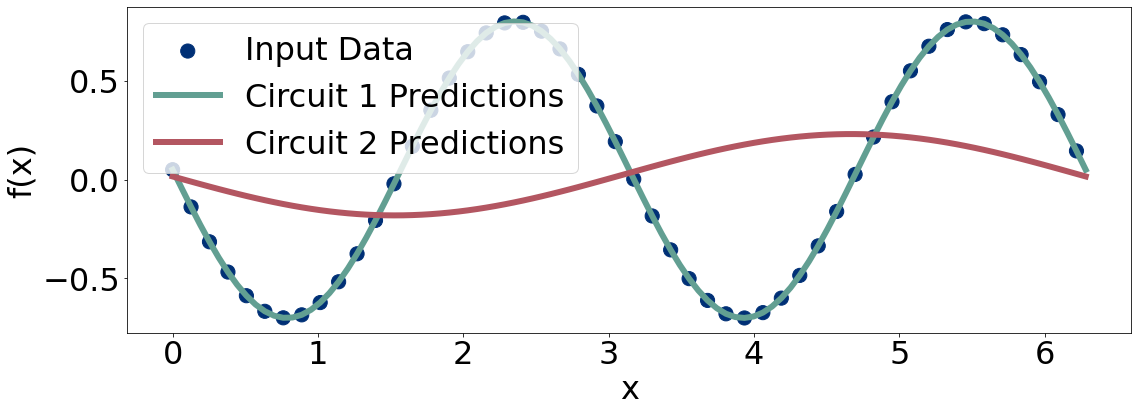

In [556]:
plt.rc('font', size=32)
plt.rc('axes', labelsize=32)
plt.rc('xtick', labelsize=32)
plt.rc('ytick', labelsize=32)

preds_1 = [circ_1(data, info_1[-1][-1]).numpy().item() for data in x]
preds_2 = [circ_2(data, info_2[-1][-1]).numpy().item() for data in d_x]

theme = np.zeros((8, 2, 3))
theme[0] = np.array([[252, 186, 185], [96, 20, 66]]) # pink
theme[1] = np.array([[184, 212, 250], [0, 48, 118]]) # blue
theme[2] = np.array([[255, 171, 181], [103, 2, 12]]) # red
theme[3] = np.array([[171, 231, 212], [24, 86, 80]]) # turqiose
theme[4] = np.array([[240, 219, 142], [123, 99, 0]]) # yellow
theme[5] = np.array([[228, 200, 249], [61, 37, 125]]) # purple
theme[6] = np.array([[247, 190, 159], [136, 46, 8]]) # orange
theme[7] = np.array([[184, 237, 155], [26, 77, 2]]) # green

theme /= 255

fig, ax = plt.subplots(1, 1, figsize=(18, 6))

# print(pred_y_1_1)

ax.scatter(x[::2], y[::2], c=[theme[1][1] for i in range(50)], label='Input Data', s=200)
ax.plot(x, preds_2, c=np.mean(theme[3], 0), linewidth=6, label='Circuit 1 Predictions')
ax.plot(x, preds_1, c=np.mean(theme[2], 0), linewidth=6, label='Circuit 2 Predictions')

# ax[1].plot(np.array(info_1[0]) / 64, c=np.mean(theme[2], 0), linewidth=3)
# ax[1].plot(np.array(info_2[0]) / 64, c=np.mean(theme[3], 0), linewidth=3)
# ax[1].scatter(x, pred_y_1_1, c=[np.mean(theme[2], 0) for i in range(30)], marker='v', label='Circuit 1 Predictions', s=150)
# ax[1].scatter(x, pred_y_2_1, c=[np.mean(theme[0], 0) for i in range(30)], marker='s', label='Circuit 2 Predictions', s=150)

ax.legend(loc=2)

# ax.scatter(x, y_2, c=[theme[1][1] for i in range(30)], label='Original Data', s=150)
# ax.scatter(x, pred_y_1_2, c=[np.mean(theme[2], 0) for i in range(30)], marker='v', label='Circuit 1 Predictions', s=150)
# ax.scatter(x, pred_y_2_2, c=[np.mean(theme[0], 0) for i in range(30)], marker='s', label='Circuit 2 Predictions', s=150)

# ax.legend(loc=1)

ax.set_xlabel(r'x')
ax.set_ylabel(r'f(x)')

# ax[1].set_xlabel('Training steps')
# ax[1].set_ylabel('MSE loss')

# ax[0].spines['top'].set_visible(False)
# ax[0].spines['right'].set_visible(False)
# ax[0].spines['bottom'].set_visible(False)
# ax[0].spines['left'].set_visible(False)

# ax[1].spines['top'].set_visible(False)
# ax[1].spines['right'].set_visible(False)
# ax[1].spines['bottom'].set_visible(False)
# ax[1].spines['left'].set_visible(False)

# ax.set_title('y = 0.75 sin(x) + 0.25', size=20)
# fig.suptitle('y = 0.66 sin(2x) - 0.33', size=20)

## classical vs quantum training time

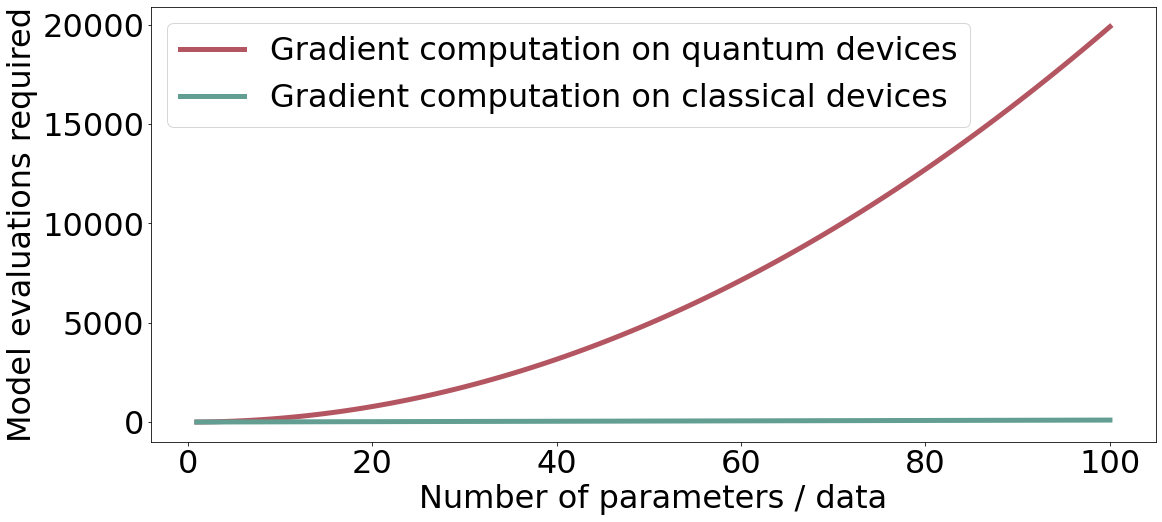

In [502]:
plt.rc('font', size=32)
plt.rc('axes', labelsize=32)
plt.rc('xtick', labelsize=32)
plt.rc('ytick', labelsize=32)

fig, ax = plt.subplots(1, 1, figsize=(18, 8))

theme = np.zeros((8, 2, 3))
theme[0] = np.array([[252, 186, 185], [96, 20, 66]]) # pink
theme[1] = np.array([[184, 212, 250], [0, 48, 118]]) # blue
theme[2] = np.array([[255, 171, 181], [103, 2, 12]]) # red
theme[3] = np.array([[171, 231, 212], [24, 86, 80]]) # turqiose
theme[4] = np.array([[240, 219, 142], [123, 99, 0]]) # yellow
theme[5] = np.array([[228, 200, 249], [61, 37, 125]]) # purple
theme[6] = np.array([[247, 190, 159], [136, 46, 8]]) # orange
theme[7] = np.array([[184, 237, 155], [26, 77, 2]]) # green

theme /= 255

ax.plot(np.arange(100) + 1, np.multiply(1 + np.arange(100), 2 * np.arange(100) + 1), c=np.mean(theme[2], 0), label="Gradient computation on quantum devices", linewidth=5)
ax.plot(np.arange(100) + 1, np.multiply(1 + np.arange(100), np.ones(100)), c=np.mean(theme[3], 0), label="Gradient computation on classical devices", linewidth=5)
# ax.scatter(np.arange(100) + 1, 2 * np.arange(100) + 1, color=np.mean(theme[2], 0), s=150)
# ax.scatter(np.arange(100) + 1, np.ones(100), color=np.mean(theme[3], 0), s=150)


ax.set_ylabel("Model evaluations required")
ax.set_xlabel("Number of parameters / data")
ax.legend()

plt.show()

In [ ]:
# plt.rc('font', size=28)
# plt.rc('axes', labelsize=28)
# plt.rc('xtick', labelsize=24)
# plt.rc('ytick', labelsize=24)

# theme = np.zeros((8, 2, 3))
# theme[0] = np.array([[252, 186, 185], [96, 20, 66]]) # pink
# theme[1] = np.array([[184, 212, 250], [0, 48, 118]]) # blue
# theme[2] = np.array([[255, 171, 181], [103, 2, 12]]) # red
# theme[3] = np.array([[171, 231, 212], [24, 86, 80]]) # turqiose
# theme[4] = np.array([[240, 219, 142], [123, 99, 0]]) # yellow
# theme[5] = np.array([[228, 200, 249], [61, 37, 125]]) # purple
# theme[6] = np.array([[247, 190, 159], [136, 46, 8]]) # orange
# theme[7] = np.array([[184, 237, 155], [26, 77, 2]]) # green

# theme /= 255

# fig, ax = plt.subplots(1, 1, figsize=(20, 8))

# ax.plot(quantum, '.-', color=np.mean(theme[2], 0), linewidth=5)
# ax.plot(classical, '.-', color=np.mean(theme[3], 0), linewidth=5)

# ax.set_xlabel('Number of parameters')
# ax.set_ylabel('')

# ax.scatter(num_params - 1, quantum, color=np.mean(theme[2], 0), s=150)
# ax.scatter(num_params - 1, classical, color=np.mean(theme[3], 0), s=150)

## Qiskit runtime

In [59]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, RuntimeOptions
from qiskit import transpile
from importlib import reload
import create_gate_circs

reload(create_gate_circs)

from create_gate_circs import create_qiskit_circ, generate_true_random_gate_circ

In [47]:
# paid instance

QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token="2YFT1_Hmj-3LVfUhsfN-p2sck1MPK_mGIZZ6Ysgzjqsa",
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/162310daae5746c9981d111c15c71838:af0eef41-67b4-4a29-b27a-8c350c153278::",
    overwrite=True
)

service = QiskitRuntimeService()

In [52]:
# free instance

QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token="2YFT1_Hmj-3LVfUhsfN-p2sck1MPK_mGIZZ6Ysgzjqsa",
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/162310daae5746c9981d111c15c71838:19cf4c87-db3c-44f9-83d0-050296523333::",
    overwrite=True
)

service = QiskitRuntimeService()

print(service.active_account())
print(service.backends())

{'channel': 'ibm_cloud', 'token': '2YFT1_Hmj-3LVfUhsfN-p2sck1MPK_mGIZZ6Ysgzjqsa', 'url': 'https://cloud.ibm.com', 'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/162310daae5746c9981d111c15c71838:19cf4c87-db3c-44f9-83d0-050296523333::', 'verify': True}
[<IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_statevector')>]


In [77]:
num_qubits = 4
num_embeds = 0
num_params = 16

ent_prob = np.random.sample()
cxz = np.random.sample()
pauli = 0

circ_gates, gate_params, inputs_bounds, weights_bounds = generate_true_random_gate_circ(num_qubits, num_embeds, num_params, 
                                                                                                        ent_prob=ent_prob, 
                                                                                                        cxz_prob=cxz * ent_prob,
                                                                                                        pauli_prob=pauli * (
                                                                                                            1 - cxz) * ent_prob)

q_circ = create_qiskit_circ(circ_gates, gate_params, inputs_bounds, weights_bounds, [0, 1, 2, 3], num_qubits)

In [81]:
c = [q_circ([], np.random.sample(16)) for i in range(2)]

noiseless_service = QiskitRuntimeService(channel="ibm_cloud",
                               token="2YFT1_Hmj-3LVfUhsfN-p2sck1MPK_mGIZZ6Ysgzjqsa",
                               instance="crn:v1:bluemix:public:quantum-computing:us-east:a/162310daae5746c9981d111c15c71838:19cf4c87-db3c-44f9-83d0-050296523333::")

options = RuntimeOptions(backend_name="ibmq_qasm_simulator")

backend = noisy_service.backend('ibm_algiers')

# t_c = transpile(c, backend, optimization_level=0, seed_transpiler=0)

with Sampler(circuits=c, service=noiseless_service, options=options, skip_transpilation=True) as sampler:
    result = sampler(circuits=c, run_options={'shots': 1024})
    print(result)

SamplerResult(quasi_dists=[{'1001': 0.0009765625, '1011': 0.0126953125, '1000': 0.0107421875, '1101': 0.0048828125, '0101': 0.0185546875, '1100': 0.0087890625, '0001': 0.07421875, '0010': 0.1162109375, '0110': 0.0166015625, '0100': 0.107421875, '1010': 0.1103515625, '0111': 0.0078125, '0000': 0.46875, '0011': 0.013671875, '1110': 0.0283203125}, {'1000': 0.0068359375, '1001': 0.0126953125, '1011': 0.017578125, '1111': 0.0283203125, '1010': 0.0556640625, '1110': 0.046875, '0010': 0.1279296875, '0001': 0.0908203125, '1101': 0.083984375, '0100': 0.046875, '0110': 0.015625, '0101': 0.0146484375, '1100': 0.1416015625, '0011': 0.03125, '0000': 0.251953125, '0111': 0.02734375}], metadata=[{'header_metadata': {}, 'shots': 1024}, {'header_metadata': {}, 'shots': 1024}])


In [323]:
program_inputs = {'iterations': 1}
options = {"backend_name": ""}
job = service.run(program_id="hello-world",
                  options=options,
                  inputs=program_inputs
                 )
print(f"job id: {job.job_id}")
result = job.result()
print(result)

job id: cd1uq87kcvv7nhfanvj0
Hello, World!


In [339]:
service.backends()

[<IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_statevector')>]

In [342]:
from create_gate_circs import generate_true_random_gate_circ, create_gate_circ

num_qubits = 2
num_embeds = 0
num_params = 5

IBMQ.load_account()
provider = IBMQ.get_provider()

dev = qml.device('qiskit.ibmq.sampler', wires=num_qubits, provider=provider, shots=1024)

circ_gates, gate_params, inputs_bounds, weights_bounds = generate_true_random_gate_circ(num_qubits, num_embeds, num_params, 
                                                                                                        ent_prob=ent_prob, 
                                                                                                        cxz_prob=cxz * ent_prob,
                                                                                                        pauli_prob=pauli * (
                                                                                                            1 - cxz) * ent_prob)

circ = create_gate_circ(dev, circ_gates, gate_params, inputs_bounds, weights_bounds, [0], 'exp', None)

ibmqfactory.load_account:WARNING:2022-10-10 10:37:43,882: Credentials are already in use. The existing account in the session will be replaced.


In [334]:
dev.capabilities()['backend']

['ibmq_qasm_simulator',
 'ibmq_lima',
 'ibmq_belem',
 'ibmq_quito',
 'simulator_statevector',
 'simulator_mps',
 'simulator_extended_stabilizer',
 'simulator_stabilizer',
 'ibmq_manila',
 'ibm_nairobi',
 'ibm_oslo']

## generate device-aware circuits

In [607]:
import qiskit

import qiskit.providers.aer.noise as noise
from qiskit import IBMQ
from qiskit_aer import AerSimulator
from qiskit_aer.noise import device as noisy_device

backend_name = 'ibmq_lima'

try:
    provider = IBMQ.enable_account(
        'f9be8ebe6cc0b5c9970ca5ae86acad18c1dfb3844ed12b381a458536fcbf46499d62dbb33da9a07627774441860c64ac44e76a6f27dc6f09bba7e0f2ce68e9ff')
except:
     provider = IBMQ.load_account()
    
backend = provider.get_backend(backend_name)
device = AerSimulator.from_backend(backend)
properties = backend.properties()

ibmqfactory.load_account:WARNING:2022-11-06 04:34:36,948: Credentials are already in use. The existing account in the session will be replaced.


In [877]:
def extract_properties_from_ibm_device(backend):
    # forced to manually enter this for now, try to find a way to programmatically get this
    gates_parameters = {'rz': 1, 'cx': 0, 'sx': 0, 'x': 0, 'y': 0, 'z': 0, 'cz': 0, 'h': 0, 'rx': 1, 'ry': 1}
    
    properties = backend.properties()
    config = backend.configuration()

    coupling_map = config.coupling_map
    num_device_qubits = config.num_qubits
    connectivity = {i : [] for i in range(num_device_qubits)}

    for i in coupling_map:
        connectivity[i[0]].append(i[1])

    t1_times = [properties.t1(i) for i in range(num_device_qubits)]
    t2_times = [properties.t2(i) for i in range(num_device_qubits)]

    readout_success_probs = [1 - properties.readout_error(i) for i in range(num_device_qubits)]
    basis_gates_raw = config.basis_gates
    basis_gates = [[], []]
    gate_param_nums = [[], []]

    for gate in basis_gates_raw:
        basis_gates[len(list(properties.gate_property(gate).keys())[0]) - 1].append(gate)

    basis_gates[0].remove('id')
    basis_gates[0].remove('reset')

    for gate in basis_gates[0] + basis_gates[1]:
        gate_param_nums[len(list(properties.gate_property(gate).keys())[0]) - 1].append(gates_parameters[gate])
    
    gate_times = [dict() for i in range(num_device_qubits)]
    
    for gate in basis_gates[0]:
        for i in range(num_device_qubits):
            gate_times[i][gate] = properties.gate_length(gate, i)

    for i in range(num_device_qubits):
        for gate in basis_gates[1]:
            gate_times[i][gate] = dict()

            for paired_qubit in connectivity[i]:
                gate_times[i][gate][paired_qubit] = properties.gate_length(gate, [i, paired_qubit])

    two_qubit_gate_success_probs = [dict() for i in range(num_device_qubits)]

    for i in range(num_device_qubits):
        for gate in basis_gates[1]:
            two_qubit_gate_success_probs[i][gate] = dict()

            for paired_qubit in connectivity[i]:
                two_qubit_gate_success_probs[i][gate][paired_qubit] = 1 - properties.gate_error(gate, [i, paired_qubit])
                
    return num_device_qubits, connectivity, t1_times, t2_times, readout_success_probs, basis_gates, gate_param_nums, gate_times, two_qubit_gate_success_probs

In [878]:
def generate_qubit_mappings(connectivity, num_qubits, num_trials):
    qubit_mappings = []
    mapping_edges = []

    sample_probs_connectivity = np.exp([len(connectivity[i]) for i in range(num_device_qubits)]).astype(np.float32)    
    sample_probs_connectivity /= np.sum(sample_probs_connectivity)
    
    for i in range(num_trials):
        curr_mapping = []
        curr_mapping.append(np.random.choice(num_device_qubits, p=sample_probs_connectivity))
        
        mapping_found = True
        
        while len(curr_mapping) < num_qubits:
            qubit_added = False
            
            for selected_qubit in np.random.permutation(curr_mapping):
                for connected_qubit in np.random.permutation(connectivity[selected_qubit]):
                    if connected_qubit not in curr_mapping:
                        qubit_added = True
                        curr_mapping.append(connected_qubit)
                        break
                        
                if qubit_added:
                    break

            if not qubit_added:
                mapping_found = False
                break

        if mapping_found and curr_mapping not in qubit_mappings:
            qubit_mappings.append(curr_mapping)   
            curr_edges = [[[qubit, paired_qubit] for paired_qubit in connectivity[qubit] if paired_qubit in curr_mapping] for qubit in curr_mapping]
            mapping_edges.append([i for j in curr_edges for i in j])
        
    return qubit_mappings, mapping_edges


def compute_mappings_quality(mappings, edges, t1_times, t2_times, meas_succ_probs, ent_succ_probs, gate_times, num_meas_qubits):
    mappings_quality = []
    coherence_times = np.mean(np.concatenate(([t1_times], [t2_times])), 0)
    
    for i in range(len(mappings)):
        curr_cnot_succ_prob = np.mean([ent_succ_probs[e[0]]['cx'][e[1]] for e in edges[i]])
        curr_coherence_time = np.mean([coherence_times[q] for q in mappings[i]])
        curr_readout_succ_prob = np.mean(np.sort(meas_succ_probs[mappings[i]][-1 * num_meas_qubits:]))
        curr_cnot_time = np.mean([gate_times[e[0]]['cx'][e[1]] for e in edges[i]])
        
        mappings_quality.append(curr_cnot_succ_prob * curr_readout_succ_prob * (curr_coherence_time / curr_cnot_time))
        
    return mappings_quality

In [1287]:
def generate_device_aware_gate_circ(ibm_backend, num_qubits, num_embed_gates, num_var_params=0, ent_prob=0.5, 
                                    param_focus=2, num_meas_qubits=1, num_trial_mappings=100, temp=1e-2):
    """
    Generate a device-aware circuit via biased random sampling, along with a qubit mapping from logical to physical
    qubit based on device connectivity and calibration data.
    """
    num_device_qubits, connectivity, t1_times, t2_times, meas_succ_probs, basis_gates, gates_param_nums, gate_times, ent_succ_probs = extract_properties_from_ibm_device(
        ibm_backend)
    
    meas_succ_probs = np.array(meas_succ_probs)
        
    # get a good qubit mapping
    
    potential_mappings, mapping_edges = generate_qubit_mappings(connectivity, num_qubits, num_trial_mappings)
    mappings_quality = compute_mappings_quality(potential_mappings, mapping_edges, t1_times, t2_times, meas_succ_probs, ent_succ_probs, gate_times, num_meas_qubits)
    mappings_quality = (np.array(mappings_quality) - np.min(mappings_quality)) / np.max(mappings_quality)
    mapping_probs = np.exp(mappings_quality)
    mapping_probs /= np.sum(mapping_probs)
    
    best_ind = np.random.choice(len(mapping_probs), p=mapping_probs)
    
    selected_mapping, selected_mapping_edges = potential_mappings[best_ind], mapping_edges[best_ind]
    sel_map = np.array(selected_mapping)
    selected_edges_processed = [[np.argwhere(sel_map == e[i]).flatten().item() for i in range(2)] for e in selected_mapping_edges]
    
    # select gates based on coherence times for each qubit, current time spent running gates on each qubit, 2q error rates on each qubit pair
    
    coherence_times = np.mean(np.concatenate(([t1_times], [t2_times])), 0)
    sel_coherence_times = coherence_times[selected_mapping]
    edge_coherence_times = np.array([min(coherence_times[e[0]], coherence_times[e[1]]) for e in selected_mapping_edges])
    cnot_success_rates = np.array([ent_succ_probs[e[0]]['cx'][e[1]] for e in selected_mapping_edges])
    num_edges = len(selected_edges_processed)
    
    circ_gates = []
    gate_params = []
    inputs_bounds = [0]
    weights_bounds = [0]
    
    num_params_in_circ = 0
    index = 0
    max_params = num_embed_gates + num_var_params
    qubit_execution_times = np.zeros(num_qubits)
    
    gate_sample_probs = [np.exp(param_focus * np.array(gates_param_nums[0])), np.exp(param_focus * np.array(gates_param_nums[1]))]
    gate_sample_probs[0] /= np.sum(gate_sample_probs[0])
    gate_sample_probs[1] /= np.sum(gate_sample_probs[1])
    gate_qubit_probs = [1 - ent_prob, ent_prob]
    
    param_indices = []
    
    while (num_params_in_circ < max_params):
        gate_num_qubits = np.random.choice(np.arange(2), p=gate_qubit_probs)
        gate_index = np.random.choice(len(basis_gates[gate_num_qubits]), p=gate_sample_probs[gate_num_qubits])
        new_gate = basis_gates[gate_num_qubits][gate_index]
        circ_gates.append(new_gate)
        
        if gate_num_qubits == 0:
            curr_qubit_probs = np.exp(-1 * np.divide(qubit_execution_times, sel_coherence_times) / temp)
            curr_qubit_probs /= np.sum(curr_qubit_probs)
            
            applied_qubit = np.random.choice(num_qubits, p=curr_qubit_probs)
            gate_params.append([applied_qubit])
            
            qubit_execution_times[applied_qubit] += gate_times[selected_mapping[applied_qubit]][new_gate]
        else:
            edge_execution_times = np.array([max(qubit_execution_times[e[0]], qubit_execution_times[e[1]]) for e in selected_edges_processed])
            curr_edge_probs = np.exp(-1 * np.divide(np.divide(edge_execution_times, cnot_success_rates), edge_coherence_times) / temp)
            curr_edge_probs /= np.sum(curr_edge_probs)

            applied_edge_ind = np.random.choice(num_edges, p=curr_edge_probs)
            applied_edge = selected_edges_processed[applied_edge_ind]
            applied_edge_raw = selected_mapping_edges[applied_edge_ind]
            gate_params.append(applied_edge)
            
            qubit_0_time = qubit_execution_times[applied_edge[0]] + gate_times[applied_edge_raw[0]][new_gate][applied_edge_raw[1]]
            qubit_1_time = qubit_execution_times[applied_edge[1]] + gate_times[applied_edge_raw[0]][new_gate][applied_edge_raw[1]]
            real_execution_time = max(qubit_0_time, qubit_1_time)
            
            qubit_execution_times[applied_edge[0]] = real_execution_time
            qubit_execution_times[applied_edge[1]] = real_execution_time
            
        new_params = gates_param_nums[gate_num_qubits][gate_index]
        num_params_in_circ += new_params

        if new_params > 0:
            param_indices.append(index)

        index += 1

    embeds_indices = np.random.choice(param_indices, num_embed_gates, False)
    
    for i in range(len(circ_gates)):
        if i not in param_indices:
            inputs_bounds.append(inputs_bounds[-1])
            weights_bounds.append(weights_bounds[-1])
        else:
            if i in embeds_indices:
                inputs_bounds.append(inputs_bounds[-1] + 1)
                weights_bounds.append(weights_bounds[-1])
            else:
                inputs_bounds.append(inputs_bounds[-1])
                weights_bounds.append(weights_bounds[-1] + 1)
                    
    # choose the best qubits to measure
    
    curr_meas_probs = np.exp(meas_succ_probs[selected_mapping] / temp)
    curr_meas_probs /= np.sum(curr_meas_probs)
    meas_qubits = np.random.choice(num_qubits, num_meas_qubits, False, p=curr_meas_probs)
        
    return circ_gates, gate_params, inputs_bounds, weights_bounds, selected_mapping, meas_qubits

In [1284]:
try:
    provider = IBMQ.enable_account(
        'f9be8ebe6cc0b5c9970ca5ae86acad18c1dfb3844ed12b381a458536fcbf46499d62dbb33da9a07627774441860c64ac44e76a6f27dc6f09bba7e0f2ce68e9ff')
except:
    provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-11-06 14:01:04,681: Credentials are already in use. The existing account in the session will be replaced.


In [1288]:
backend = provider.get_backend('ibmq_lima')

num_qubits = 4
num_embed_gates = 16
num_params = 24

generate_device_aware_gate_circ(backend, num_qubits, num_embed_gates, num_params, ent_prob=0.2, 
                                    param_focus=1, num_meas_qubits=2, num_trial_mappings=25, temp=1e-2)

(['x',
  'sx',
  'rz',
  'sx',
  'cx',
  'sx',
  'cx',
  'sx',
  'cx',
  'rz',
  'rz',
  'x',
  'x',
  'sx',
  'rz',
  'sx',
  'x',
  'rz',
  'rz',
  'rz',
  'rz',
  'x',
  'sx',
  'cx',
  'cx',
  'x',
  'rz',
  'x',
  'x',
  'x',
  'rz',
  'rz',
  'cx',
  'cx',
  'rz',
  'sx',
  'sx',
  'cx',
  'cx',
  'rz',
  'rz',
  'rz',
  'x',
  'rz',
  'cx',
  'cx',
  'rz',
  'rz',
  'x',
  'rz',
  'rz',
  'rz',
  'rz',
  'x',
  'sx',
  'rz',
  'x',
  'sx',
  'cx',
  'rz',
  'cx',
  'x',
  'sx',
  'rz',
  'rz',
  'rz',
  'cx',
  'rz',
  'rz',
  'rz',
  'rz',
  'rz',
  'cx',
  'rz',
  'rz',
  'x',
  'sx',
  'x',
  'x',
  'rz',
  'sx',
  'cx',
  'rz',
  'rz',
  'cx',
  'rz',
  'rz',
  'cx',
  'x',
  'x',
  'rz'],
 [[0],
  [2],
  [0],
  [3],
  [1, 0],
  [2],
  [0, 2],
  [2],
  [1, 0],
  [1],
  [0],
  [1],
  [1],
  [3],
  [3],
  [1],
  [2],
  [1],
  [1],
  [2],
  [3],
  [3],
  [2],
  [0, 1],
  [2, 0],
  [1],
  [0],
  [3],
  [3],
  [3],
  [1],
  [1],
  [0, 1],
  [1, 0],
  [3],
  [3],
  [1],
  [0, 2],


In [25]:
losses = []
num_params = []

for i in range(1000):
    losses.append(np.mean(np.genfromtxt('./experiment_data/mnist_4/trained_circuits/circ_{}/val_losses.txt'.format(i + 1))))
    num_params.append(np.genfromtxt('./experiment_data/mnist_4/trained_circuits/circ_{}/weights_bounds.txt'.format(i + 1))[-1])

In [ ]:
edge_mat = np.array([[0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], [0, 0, 1, 0]])

print(np.linalg.)